In [ ]:
#This notebook should be used after the fits were done in video_analysis_main.ipynb

In [1]:
#Import necessary libraries - should work mostly from BCI_analysis + matplotlib + numpy
import BCI_analysis
from BCI_analysis.pipeline import pipeline_regression
import importlib
importlib.reload(pipeline_regression)
importlib.reload(BCI_analysis)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [2]:
#load multi-session mat files

#multisession_mat_file = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_new_old2.mat")
multisession_mat_file = os.path.abspath("/home/jupyter/temp/combined_new_old2.mat")
#multisession_mat_file_behavior = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_behavior.mat")
multisession_mat_file_behavior = os.path.abspath("/home/jupyter/temp/combined_behavior.mat")

# print('loading multi-session imaging data...')
multi_session_data = BCI_analysis.io_matlab.read_multisession_mat_2022(multisession_mat_file)
print('loading multi-session behavior data...')
multi_session_behavior_data = BCI_analysis.io_matlab.read_multisession_behavior_mat(multisession_mat_file_behavior)



loading multi-session behavior data...


In [98]:
# using data from .mat file 
from oasis.functions import deconvolve
importlib.reload(BCI_analysis)
dlc_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba/")
aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned/")
plt_save_path = os.path.abspath("/home/jupyter/Plots/")
face_rhythm_base_dir = '/home/jupyter/bucket/Data/Behavior_videos/FaceRhythm/'
motion_energy_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/MotionEnergy/Bergamo-2P-Photostim/")
raw_video_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/raw/Bergamo-2P-Photostim/")

multi_session_dict = {'mouse':[],
                     'session':[],
                      'mat_idx':[],
                     'cn':[],
                     'DLC_aligned':[],
                     'F':[],
                     'trial_end_frames':[],
                     'F_original':[],
                     'trial_start_original':[],
                     'reward_original':[],
                     'photostim_distance':[],
                     'photostim_amplitude':[],
                     'photostim_amplitude_error':[],                      
                     'photostim_group':[],
                     'photostim_cell':[]}
#needed_subject = 'BCI34'
do_deconvolve = False
#aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/")
for mat_session_index in range(len(multi_session_behavior_data['session'])):
    # if multi_session_behavior_data['mouse'][mat_session_index] != needed_subject:
    #     continue
    # try:
    try:
        mouse = multi_session_behavior_data['mouse'][mat_session_index][:3]+'_'+multi_session_behavior_data['mouse'][mat_session_index][3:]
    except:
        print('mouse ID missing, skipping')
        continue
    session = multi_session_behavior_data['session'][mat_session_index]
    camera = "side"
    data = {'F':multi_session_behavior_data['df_closedLoop'][mat_session_index].T,
           'trial_start':multi_session_behavior_data['trial_start'][mat_session_index],
           'reward':multi_session_behavior_data['rew'][mat_session_index],
           'cn':int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1,
           'si':multi_session_behavior_data['dt_si'][mat_session_index].tolist()}

    if do_deconvolve:
        spikes_matrix= []
        for F_trace in data['F']:
            c, s, b_, g_, lam = deconvolve(F_trace, penalty=1) 
            spikes_matrix.append(s)
        data['F'] = np.asarray(spikes_matrix)


    dict_aligned = BCI_analysis.pipeline_align.get_aligned_data(suite2p_path, 
                                                                dlc_base_dir, 
                                                                bpod_path, 
                                                                sessionwise_data_path, 
                                                                aligned_data_path, 
                                                                motion_energy_base_dir,
                                                                raw_video_path,
                                                                mouse=mouse, 
                                                                FOV=None, 
                                                                camera=camera, 
                                                                session=session, 
                                                                sampling='down', 
                                                                functions = ['diff','diff_signed','mean'],
                                                                function_window = 20,  ### important variable for downsampling 1 for facerhythm - 20/200 for DLC
                                                                convolve_tau = 0, #.7
                                                                plot = False,
                                                                overwrite=False,
                                                                use_provided_data=True,
                                                                add_motion_energy = False,
                                                                source_data = data,
                                                                face_rhythm_base_dir = face_rhythm_base_dir,
                                                                use_face_rhythm = False,
                                                                match_with_face_rhythm = False)
    DLC_aligned = pd.DataFrame.from_dict(dict_aligned['DLC_aligned'])
    F = np.concatenate(dict_aligned['F_aligned'], axis=1)

    multi_session_dict['mouse'].append(multi_session_behavior_data['mouse'][mat_session_index])
    multi_session_dict['session'].append(multi_session_behavior_data['session'][mat_session_index])
    multi_session_dict['cn'].append(int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1)
    multi_session_dict['mat_idx'].append(mat_session_index)
    multi_session_dict['DLC_aligned'].append(DLC_aligned)
    multi_session_dict['F'].append(F)
    multi_session_dict['trial_end_frames'].append(dict_aligned['trial_start_indices'])
    multi_session_dict['F_original'].append(data['F'])
    multi_session_dict['trial_start_original'].append(data['trial_start'])
    multi_session_dict['reward_original'].append(multi_session_behavior_data['rew'][mat_session_index])
    multi_session_dict['photostim_distance'].append(multi_session_data['x'][mat_session_index])
    multi_session_dict['photostim_amplitude'].append(multi_session_data['y'][mat_session_index])
    multi_session_dict['photostim_amplitude_error'].append(multi_session_data['e'][mat_session_index])
    multi_session_dict['photostim_group'].append(multi_session_data['GRP'][mat_session_index])
    multi_session_dict['photostim_cell'].append(multi_session_data['id'][mat_session_index])

    #break
        
        
    # except:
    #     print('no luck with session {}'.format(mat_session_index))

print(dict_aligned.keys())



File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/062922-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/063022-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/070122-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/062922-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/063022-dict_aligned-downsamp

dict_keys(['mouse', 'session', 'mat_idx', 'cn', 'DLC_aligned', 'F', 'trial_end_frames', 'F_original', 'trial_start_original', 'reward_original', 'photostim_distance', 'photostim_amplitude', 'photostim_amplitude_error', 'photostim_group', 'photostim_cell', 'F_trialwise', 'F_rewardwise', 'amplitude', 'previous_amplitude', 'delta_amplitude', 'p_increase', 'p_decrease', 'baseline_amplitude', 'pairwise_correlations_matrix', 'pairwise_correlations_matrix_p', 'pearson_cc_with_cn', 'pearson_cc_with_cn_yesterday'])

['BCI33', '062722']
['BCI33', '062822']
['BCI33', '062922']
['BCI33', '063022']
['BCI33', '070122']
['BCI34', '062722']
['BCI34', '062822']
['BCI34', '062922']
['BCI34', '063022']
['BCI35', '062822']
['BCI35', '062922']
['BCI35', '063022']
['BCI35', '070122']
['BCI37', '062822']
['BCI37', '062922']
['BCI37', '063022']
['BCI37', '070122']


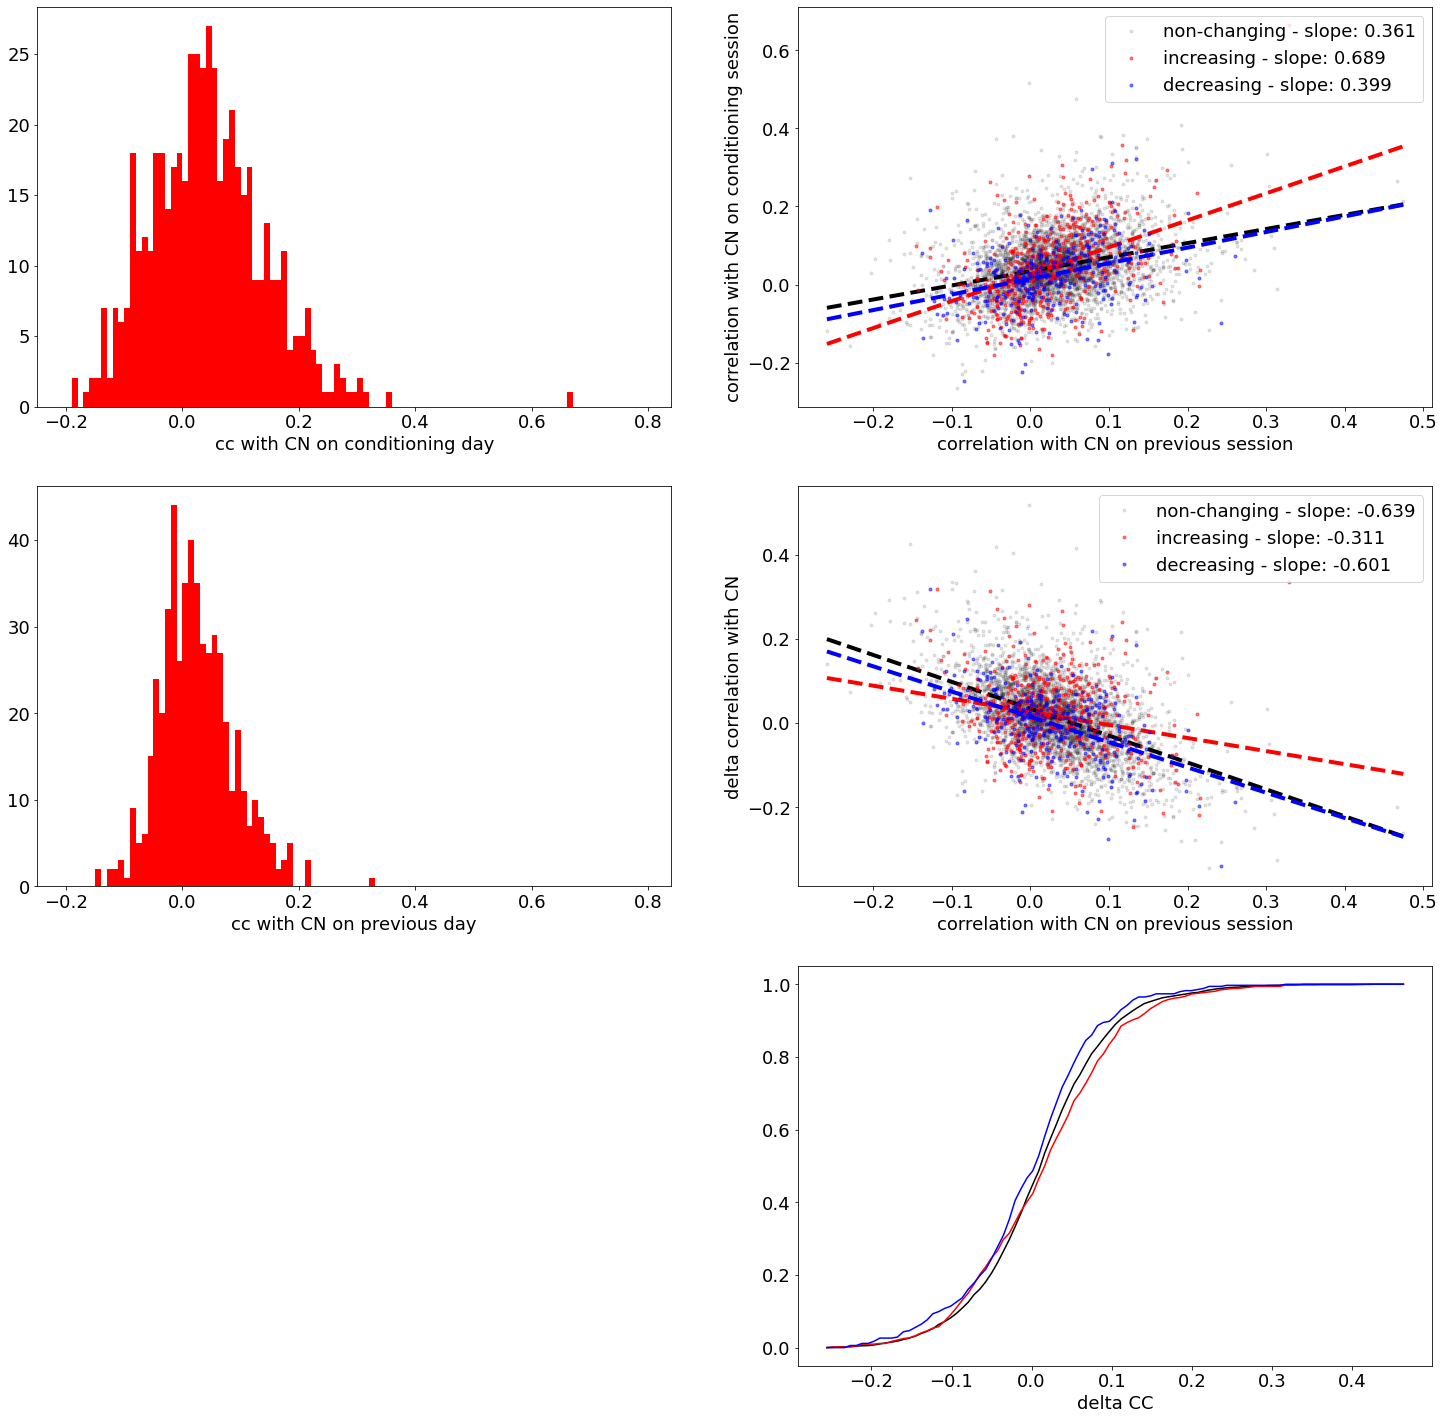

In [223]:
ccs_increasing = []
cc_all_rest = []
ccs_increasing_prev = []
ccs_all_rest_prev = []
ccs_decreasing = []
ccs_decreasing_prev = []

for session_i,session in enumerate(multi_session_dict['session']):
    print([multi_session_dict['mouse'][session_i],session])
    if session_i >0:
        if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i-1].shape[0]: #there is a previous session
            multi_session_dict['F'][session_i]
            cn = multi_session_dict['cn'][session_i]
            increasing_cells = multi_session_dict['p_increase'][session_i]<=.01
            non_changing_cells = (multi_session_dict['p_increase'][session_i]>=.1) & (multi_session_dict['p_decrease'][session_i]>=.1)
            decreasing_cells = multi_session_dict['p_decrease'][session_i]<=.01
            ccs = multi_session_dict['pearson_cc_with_cn'][session_i][increasing_cells]
            ccs_rest = multi_session_dict['pearson_cc_with_cn'][session_i][non_changing_cells]
            ccs_prev = multi_session_dict['pearson_cc_with_cn_yesterday'][session_i][increasing_cells]
            ccs_rest_prev = multi_session_dict['pearson_cc_with_cn_yesterday'][session_i][non_changing_cells]
            ccs_decreasing_now = multi_session_dict['pearson_cc_with_cn'][session_i][decreasing_cells]
            ccs_decreasing_now_prev = multi_session_dict['pearson_cc_with_cn_yesterday'][session_i][decreasing_cells]
            
            
            
            ccs_increasing.append(ccs)
            ccs_increasing_prev.append(ccs_prev)
            cc_all_rest.append(ccs_rest)
            ccs_all_rest_prev.append(ccs_rest_prev)
            ccs_decreasing.append(ccs_decreasing_now)
            ccs_decreasing_prev.append(ccs_decreasing_now_prev)
            
            
            
ccs_increasing = np.concatenate(ccs_increasing)
ccs_increasing_prev = np.concatenate(ccs_increasing_prev)
todel = np.isnan(ccs_increasing) | np.isnan(ccs_increasing_prev)
ccs_increasing = ccs_increasing[todel==False]
ccs_increasing_prev = ccs_increasing_prev[todel==False]

cc_all_rest = np.concatenate(cc_all_rest)
ccs_all_rest_prev = np.concatenate(ccs_all_rest_prev)
todel = np.isnan(cc_all_rest) | np.isnan(ccs_all_rest_prev)
cc_all_rest = cc_all_rest[todel==False]
ccs_all_rest_prev = ccs_all_rest_prev[todel==False]

ccs_decreasing = np.concatenate(ccs_decreasing)
ccs_decreasing_prev = np.concatenate(ccs_decreasing_prev)
todel = np.isnan(ccs_decreasing) | np.isnan(ccs_decreasing_prev)
ccs_decreasing = ccs_decreasing[todel==False]
ccs_decreasing_prev = ccs_decreasing_prev[todel==False]




fig = plt.figure(figsize = [25,25])
ax1 = fig.add_subplot(3,2,1)
ax1.hist(ccs_increasing,np.arange(-.2,.8,.01),color= 'red')
ax1.set_xlabel('cc with CN on conditioning day')

ax4 = fig.add_subplot(3,2,3,sharex = ax1)
ax4.hist(ccs_increasing_prev,np.arange(-.2,.8,.01),color= 'red')
ax4.set_xlabel('cc with CN on previous day')


ax2 = fig.add_subplot(3,2,2)
p_rest = np.polyfit(ccs_all_rest_prev,cc_all_rest,1)

ax2.plot(ccs_all_rest_prev,cc_all_rest,'k.',alpha = .1, label = 'non-changing - slope: {}'.format(np.round(p_rest[0],3)))
xvals = np.percentile(ccs_all_rest_prev,[0,100])
yvals = np.polyval(p_rest,xvals)
ax2.plot(xvals,yvals,'k--',linewidth = 4)


p = np.polyfit(ccs_increasing_prev,ccs_increasing,1)
ax2.plot(ccs_increasing_prev,ccs_increasing,'r.',alpha = .5, label = 'increasing - slope: {}'.format(np.round(p[0],3)))

xvals = np.percentile(ccs_all_rest_prev,[0,100])
yvals = np.polyval(p,xvals)
ax2.plot(xvals,yvals,'r--',linewidth = 4)


p = np.polyfit(ccs_decreasing_prev,ccs_decreasing,1)
ax2.plot(ccs_decreasing_prev,ccs_decreasing,'b.',alpha = .5, label = 'decreasing - slope: {}'.format(np.round(p[0],3)))
xvals = np.percentile(ccs_all_rest_prev,[0,100])
yvals = np.polyval(p,xvals)
ax2.plot(xvals,yvals,'b--',linewidth = 4)


ax2.set_xlabel('correlation with CN on previous session')
ax2.set_ylabel('correlation with CN on conditioning session')
ax2.legend()


corr_diff_increasing = ccs_increasing - ccs_increasing_prev
corr_diff_rest = cc_all_rest - ccs_all_rest_prev
corr_diff_decreasing = ccs_decreasing - ccs_decreasing_prev

bin_num = 100
x_bins = np.arange(np.percentile(ccs_all_rest_prev,0),
                   np.percentile(ccs_all_rest_prev,100),
                   np.diff(np.percentile(ccs_all_rest_prev,[0,100]))/bin_num)
y_increasing,x = np.histogram(corr_diff_increasing,x_bins)
y_decreasing,x = np.histogram(corr_diff_decreasing,x_bins)
y_rest,x = np.histogram(corr_diff_rest,x_bins)
x_bins = np.nanmean([x_bins[1:],x_bins[:-1]],0)

ax3 = fig.add_subplot(3,2,6)
ax3.plot(x_bins,np.cumsum(y_rest)/sum(y_rest),'k-')
ax3.plot(x_bins,np.cumsum(y_increasing)/sum(y_increasing),'r-')
ax3.plot(x_bins,np.cumsum(y_decreasing)/sum(y_decreasing),'b-')
ax3.set_xlabel('delta CC')

ax5 = fig.add_subplot(3,2,4)
p_rest = np.polyfit(ccs_all_rest_prev,cc_all_rest-ccs_all_rest_prev,1)

ax5.plot(ccs_all_rest_prev,cc_all_rest-ccs_all_rest_prev,'k.',alpha = .1, label = 'non-changing - slope: {}'.format(np.round(p_rest[0],3)))
xvals = np.percentile(ccs_all_rest_prev,[0,100])
yvals = np.polyval(p_rest,xvals)
ax5.plot(xvals,yvals,'k--',linewidth = 4)


p = np.polyfit(ccs_increasing_prev,ccs_increasing-ccs_increasing_prev,1)
ax5.plot(ccs_increasing_prev,ccs_increasing-ccs_increasing_prev,'r.',alpha = .5, label = 'increasing - slope: {}'.format(np.round(p[0],3)))

xvals = np.percentile(ccs_all_rest_prev,[0,100])
yvals = np.polyval(p,xvals)
ax5.plot(xvals,yvals,'r--',linewidth = 4)


p = np.polyfit(ccs_decreasing_prev,ccs_decreasing-ccs_decreasing_prev,1)
ax5.plot(ccs_decreasing_prev,ccs_decreasing-ccs_decreasing_prev,'b.',alpha = .5, label = 'decreasing - slope: {}'.format(np.round(p[0],3)))
xvals = np.percentile(ccs_all_rest_prev,[0,100])
yvals = np.polyval(p,xvals)
ax5.plot(xvals,yvals,'b--',linewidth = 4)
ax5.set_xlabel('correlation with CN on previous session')
ax5.set_ylabel('delta correlation with CN')
ax5.legend()
#plt.plot(ccs_all_prev,cc_all,'k.')
#plt.hist(cc_all_rest,50)

['BCI33', '062722']
['BCI33', '062822']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI33', '062922']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI33', '063022']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI33', '070122']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI34', '062722']
['BCI34', '062822']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI34', '062922']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI34', '063022']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI35', '062822']
['BCI35', '062922']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI35', '063022']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI35', '070122']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI37', '062822']
['BCI37', '062922']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI37', '063022']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

['BCI37', '070122']


/tmp/ipykernel_32214/3391243437.py:103: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:105: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:204: RuntimeWarning: All-NaN axis encountered
  x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:205: RuntimeWarning: All-NaN axis encountered
  y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
/tmp/ipykernel_32214/3391243437.py:246: RuntimeWarning: Mean of empty slice
  matr

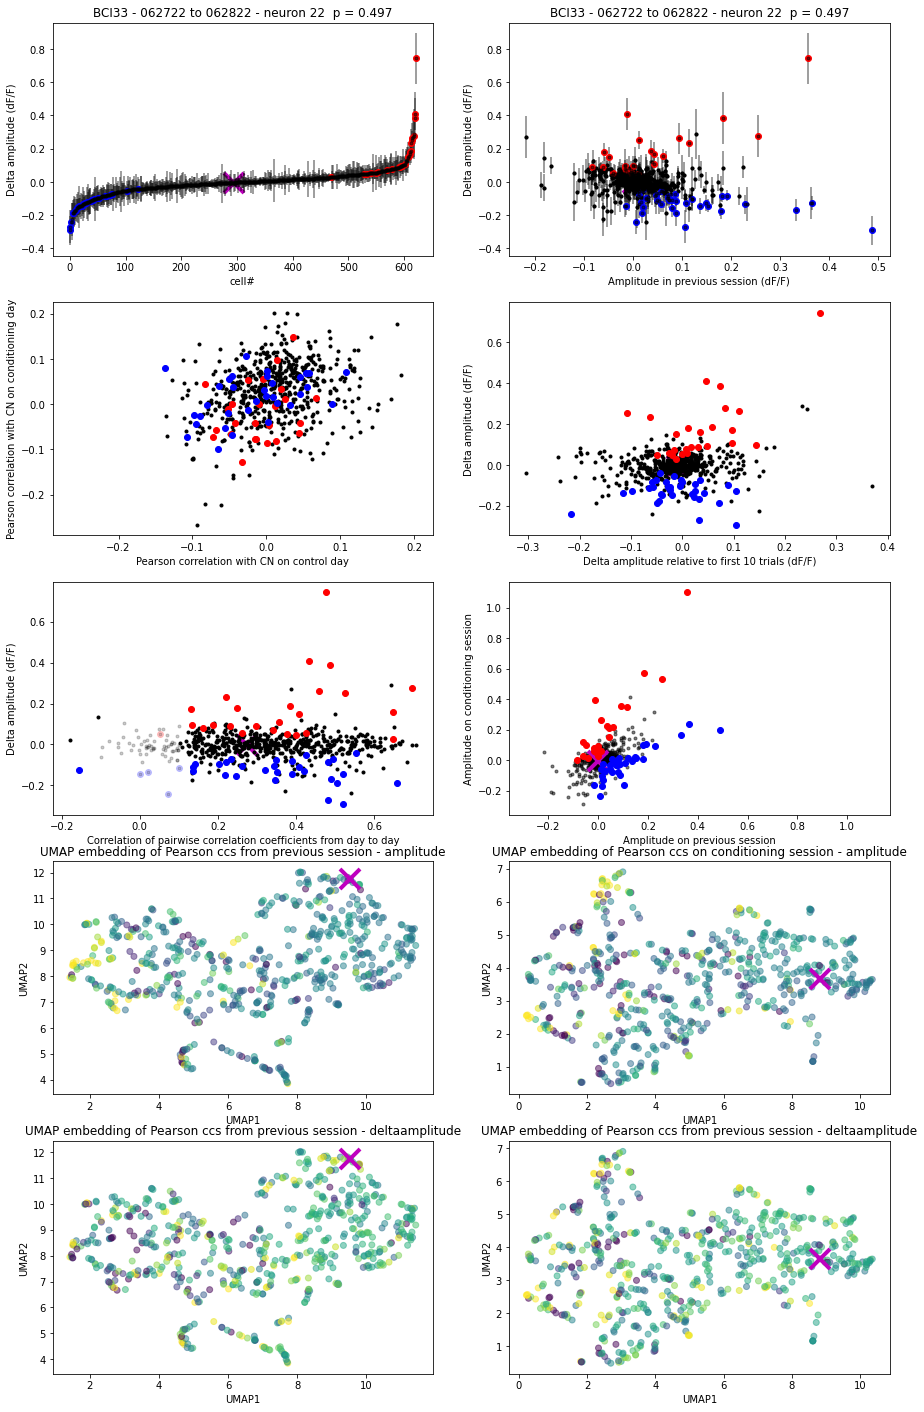

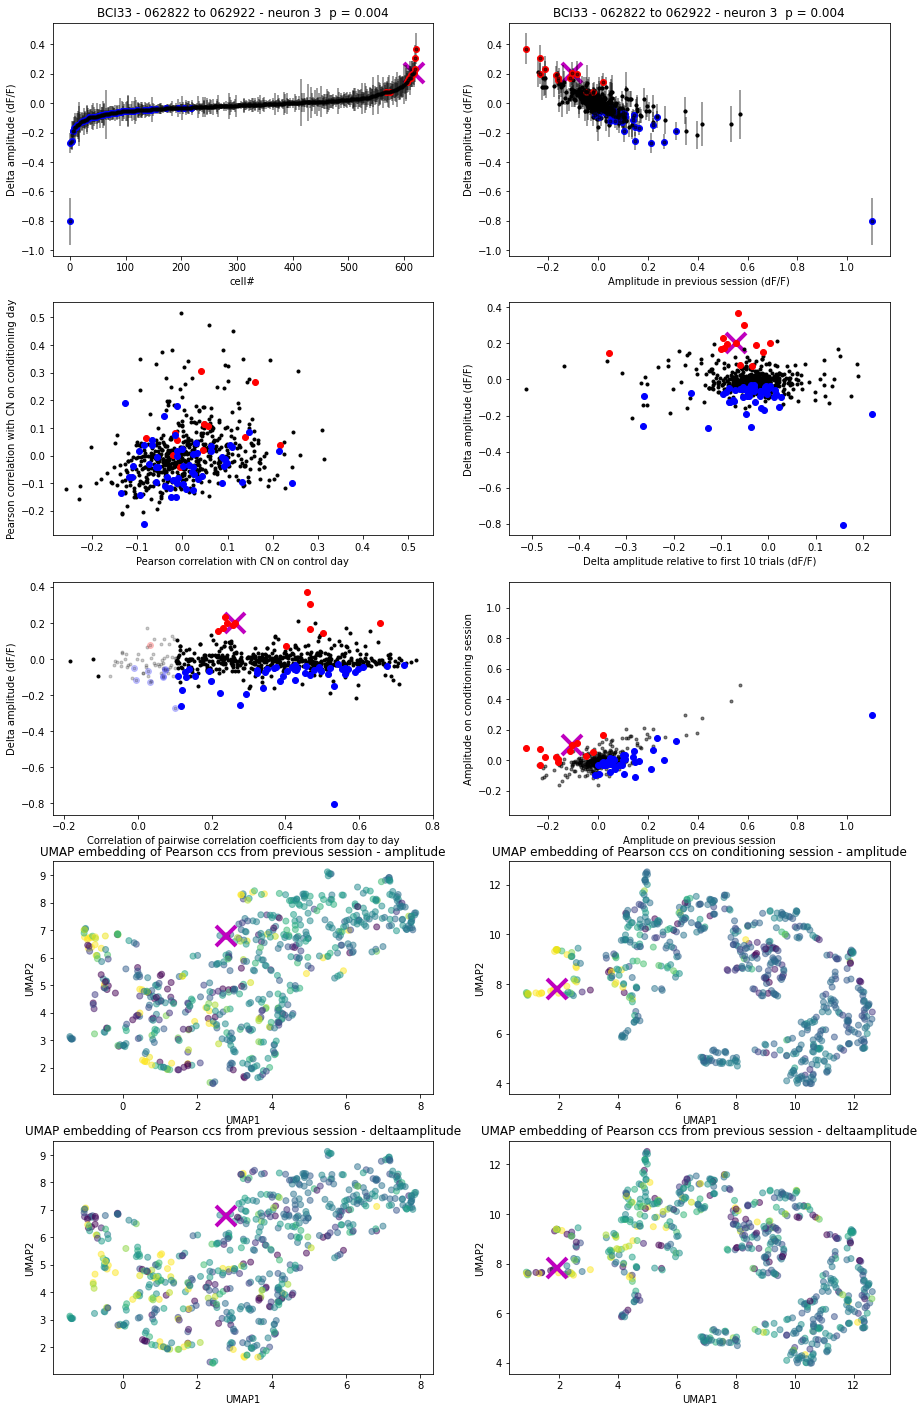

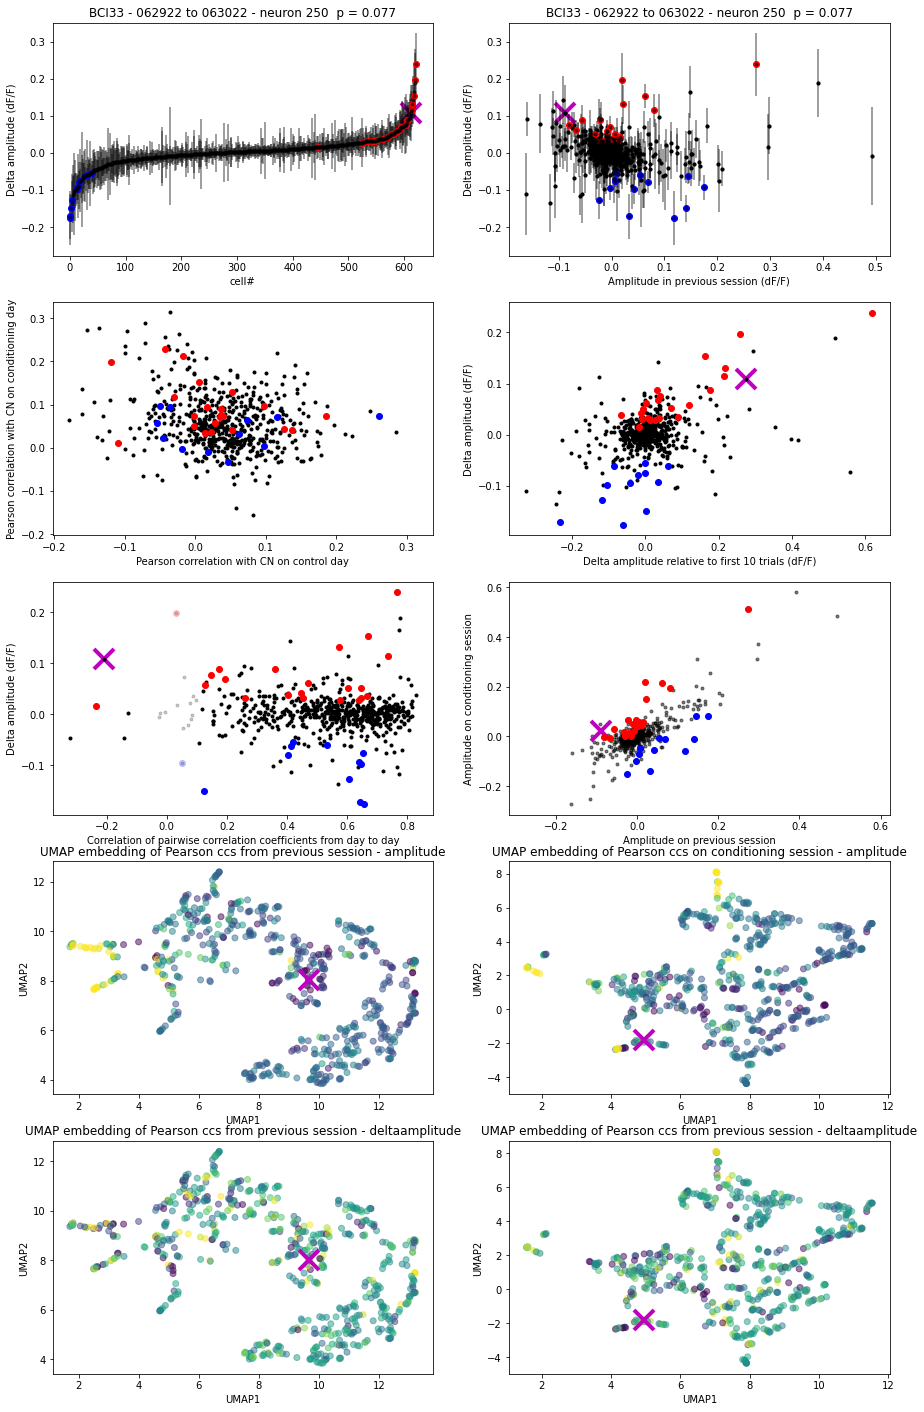

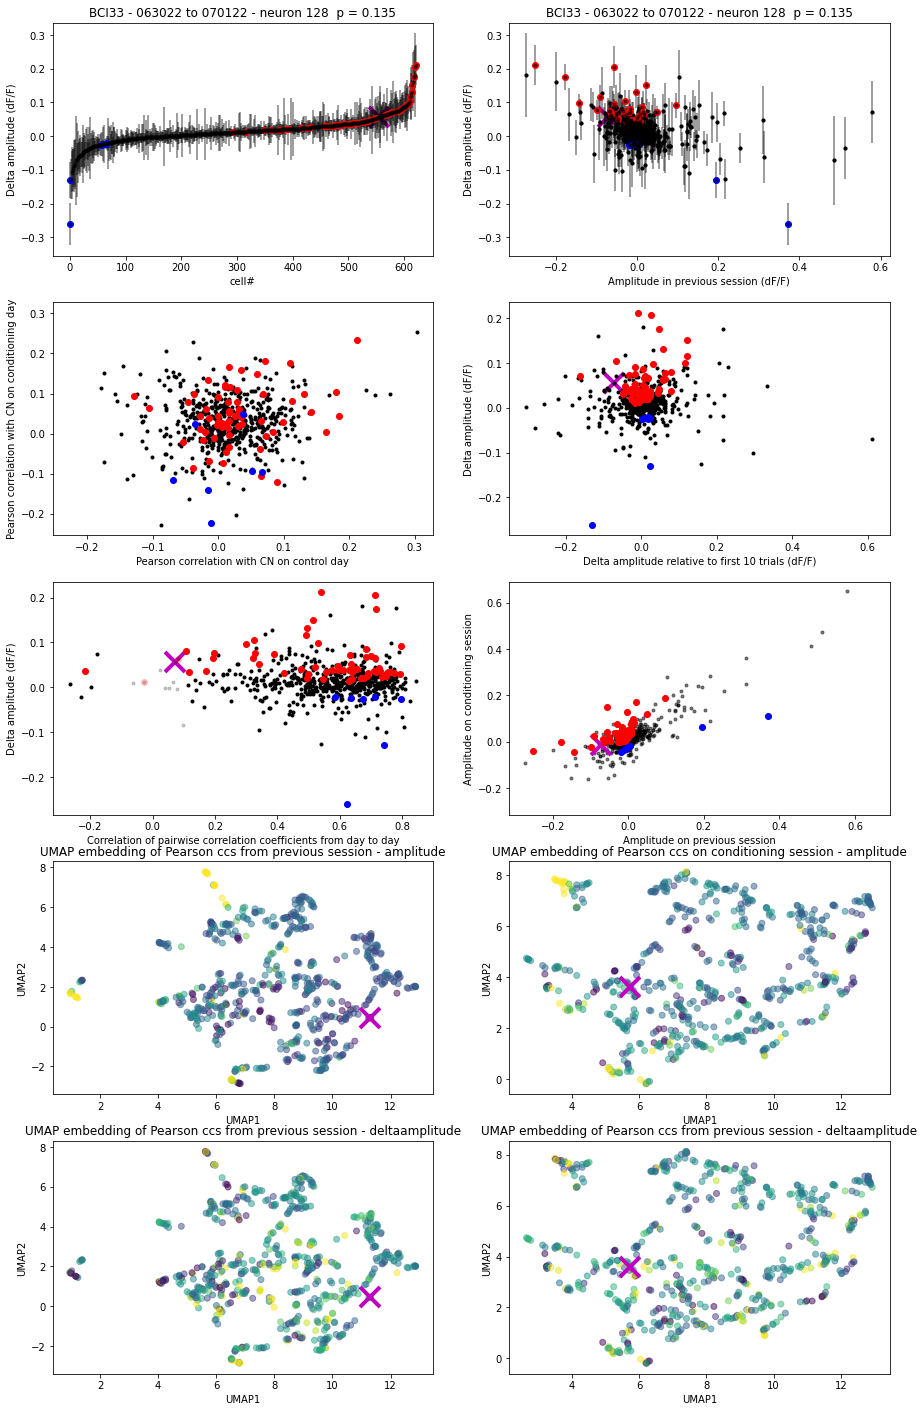

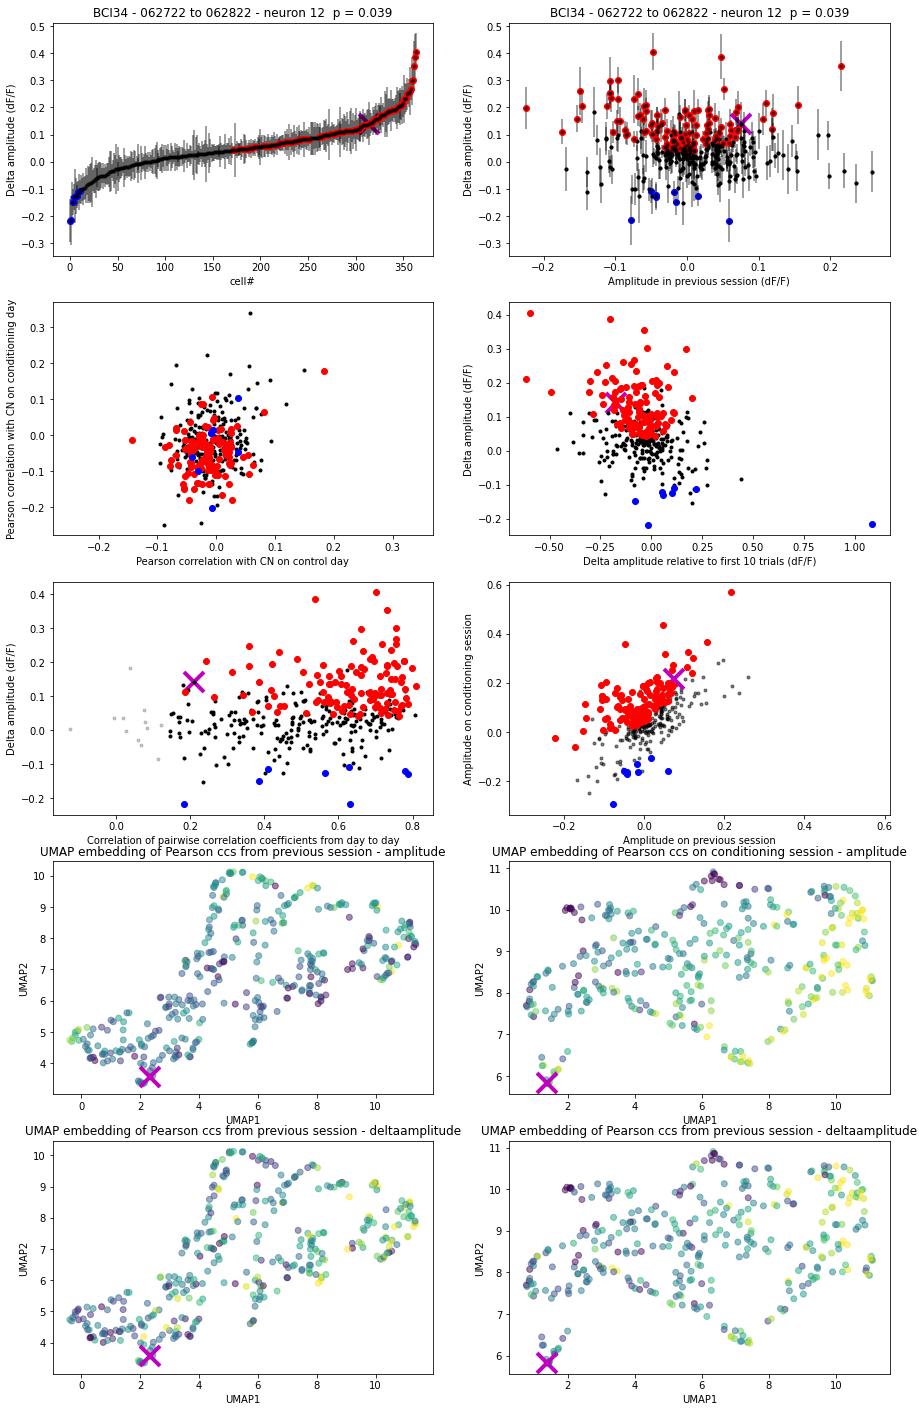

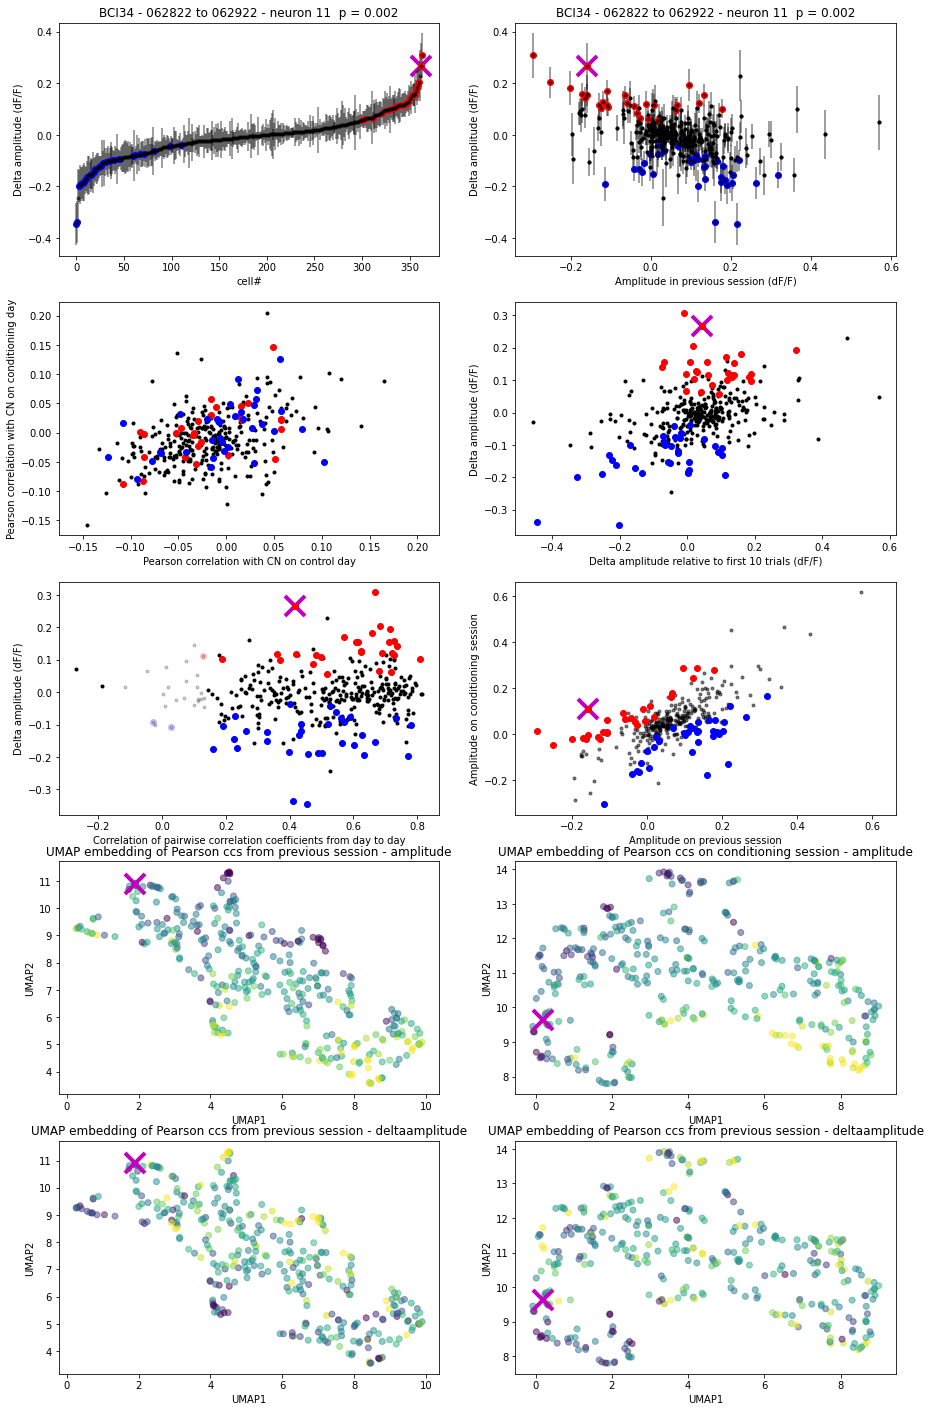

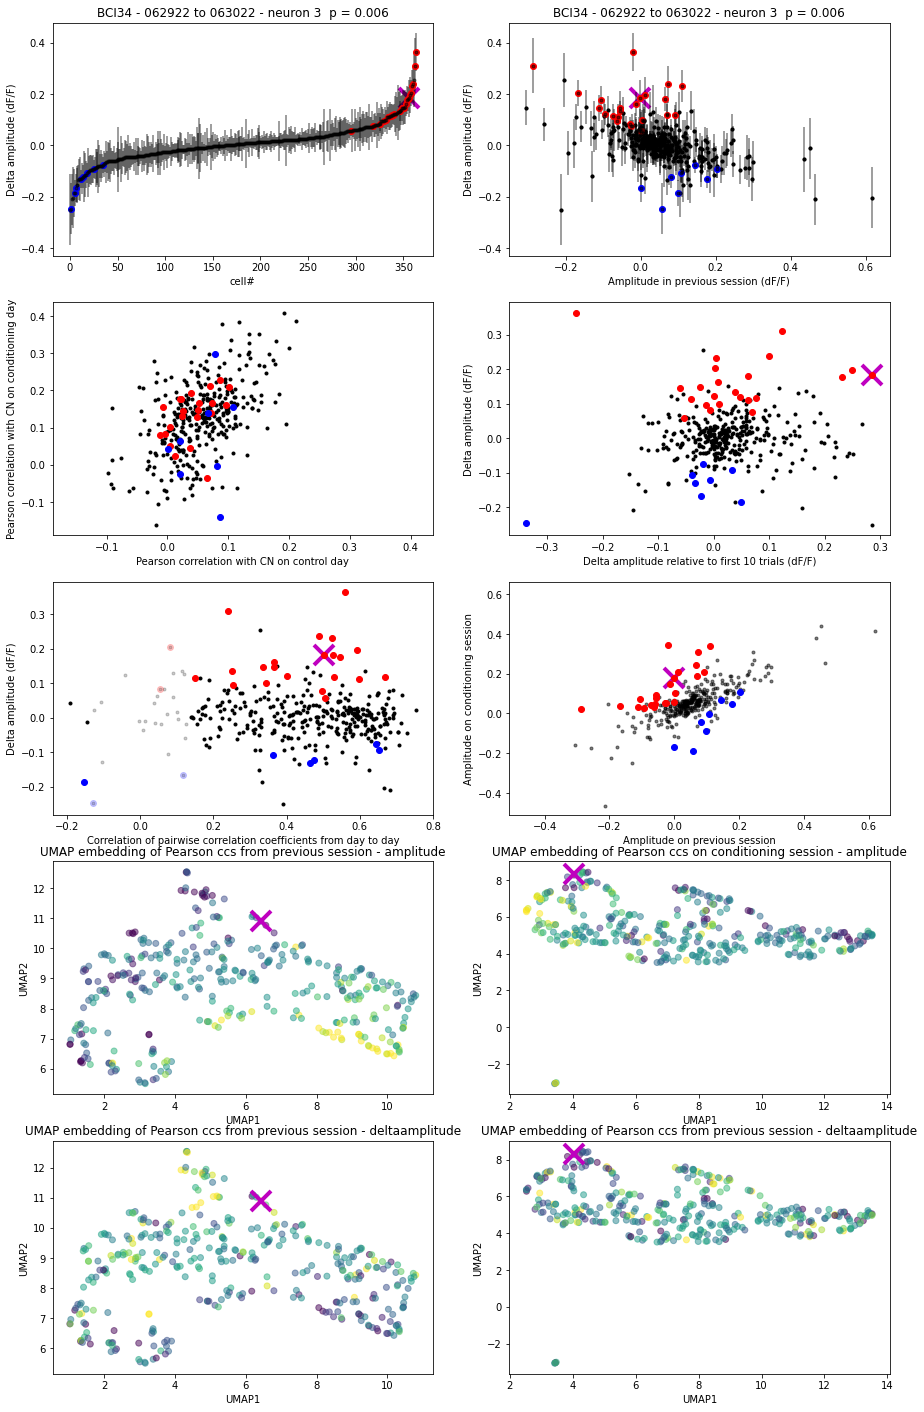

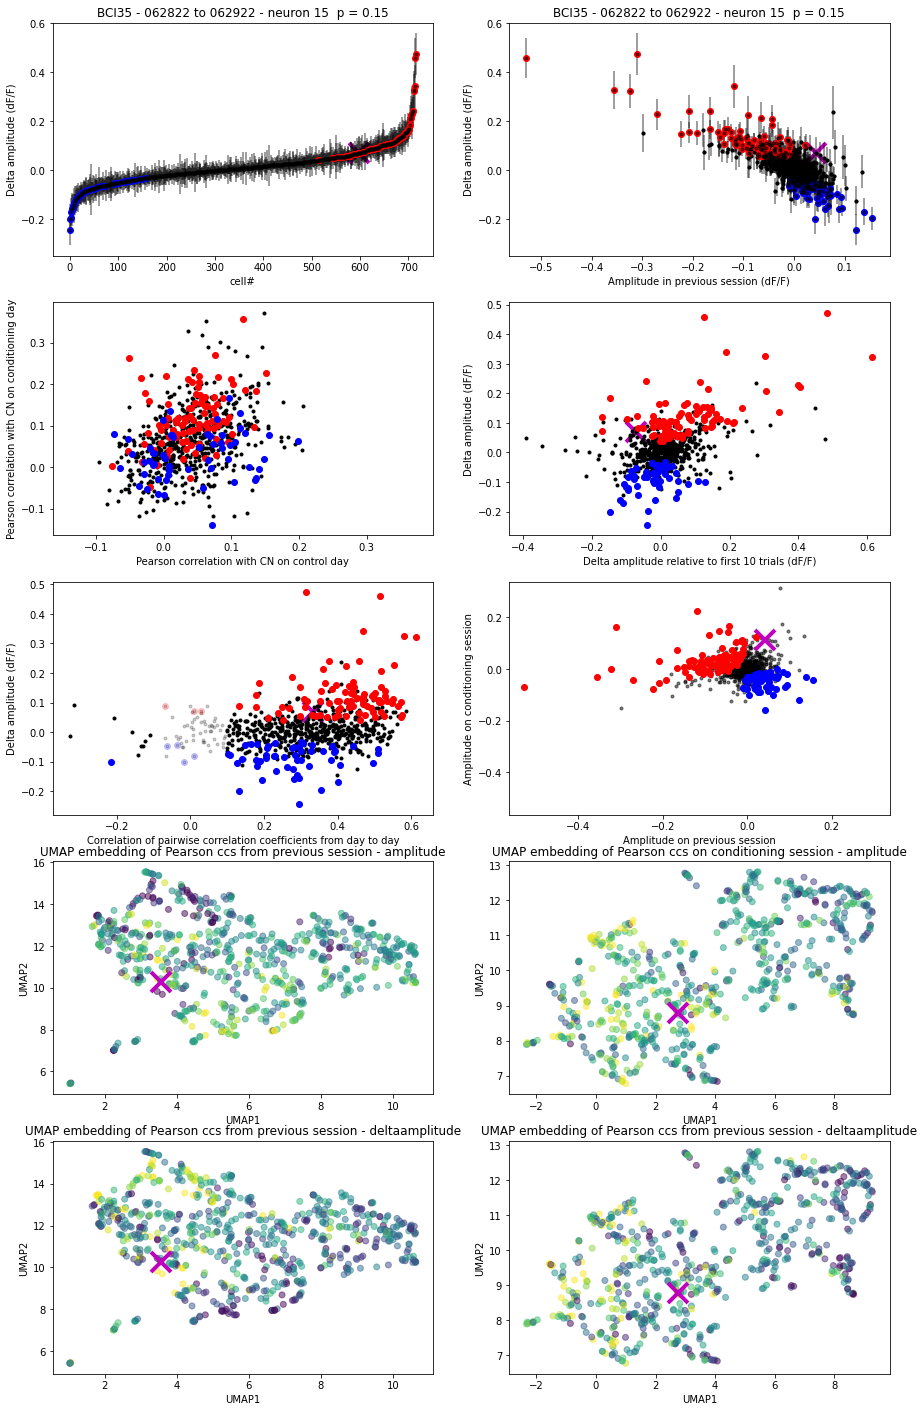

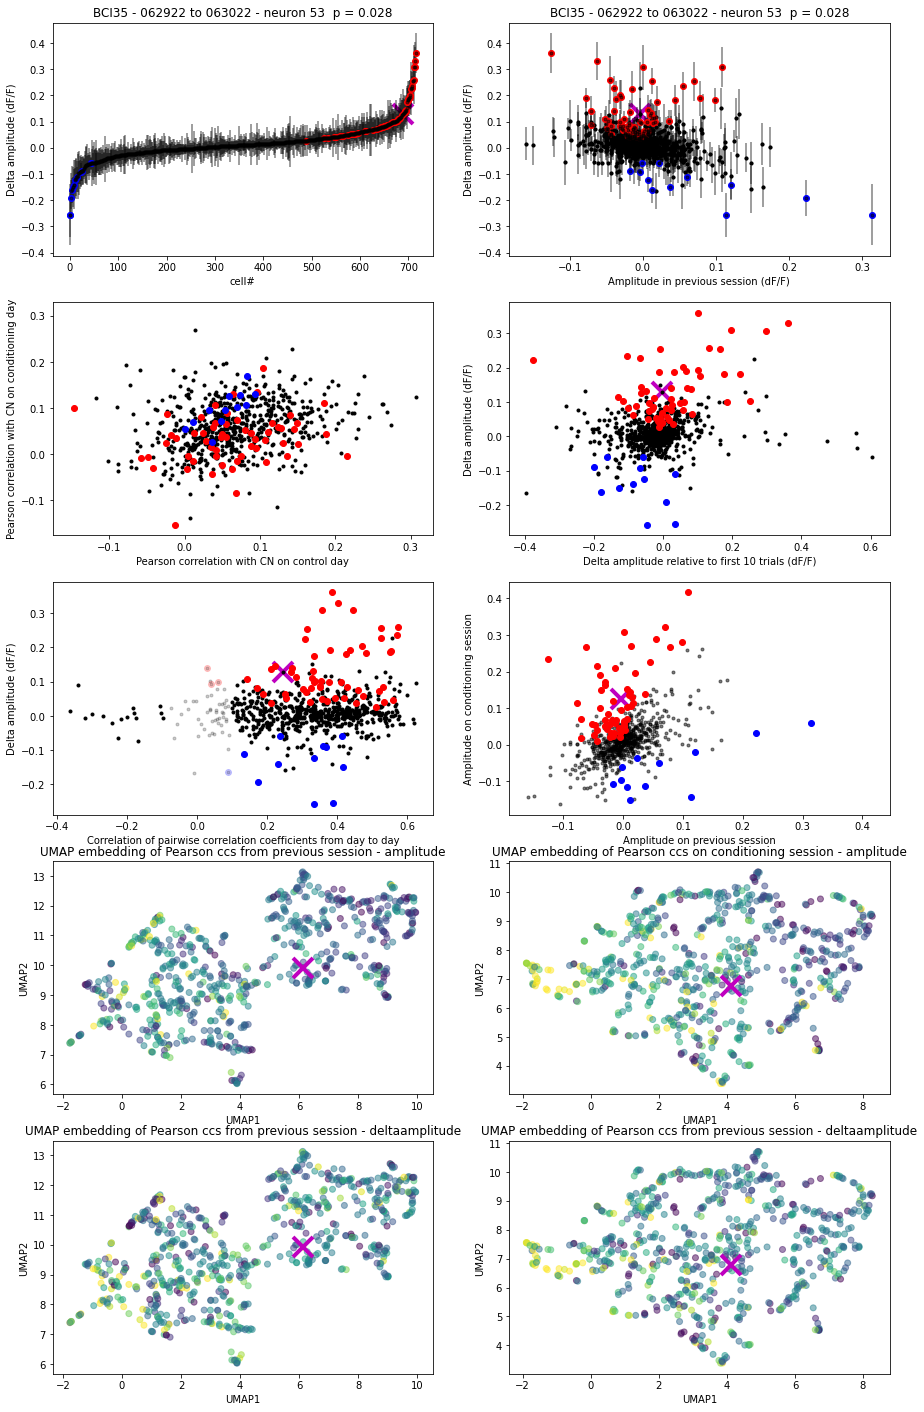

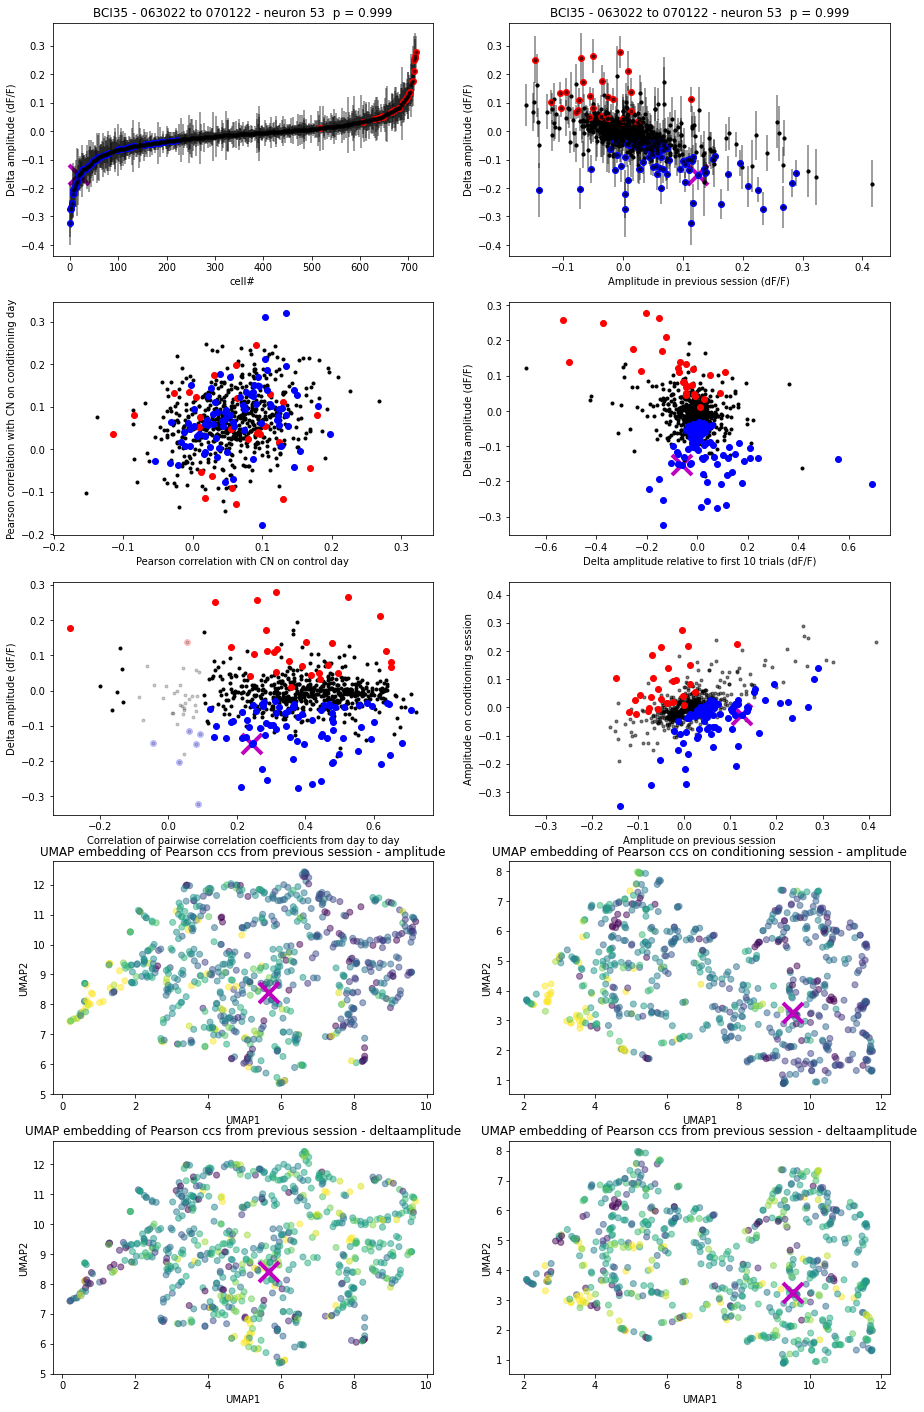

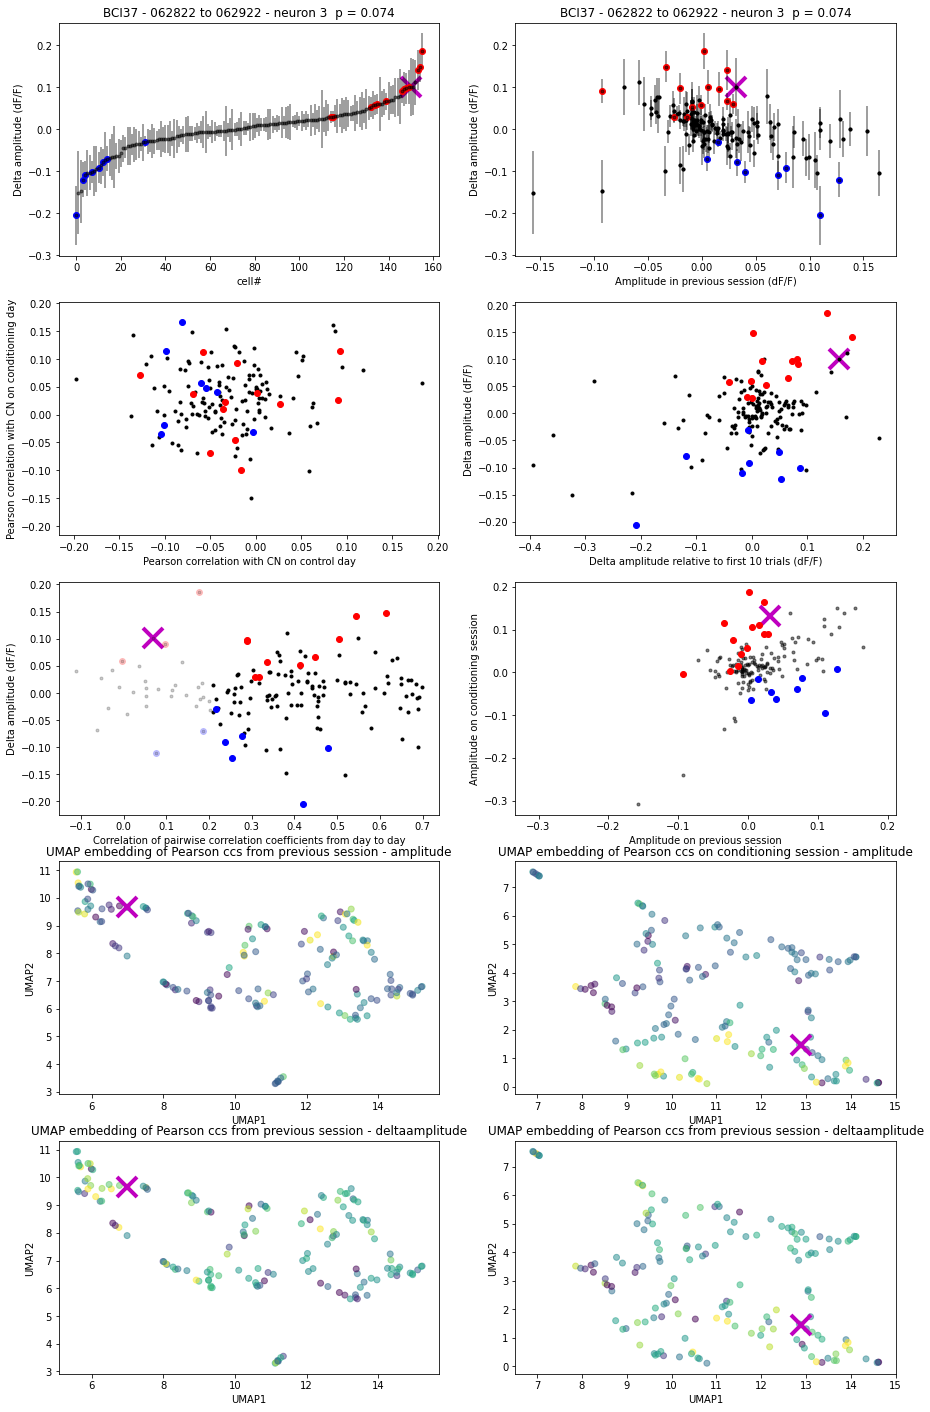

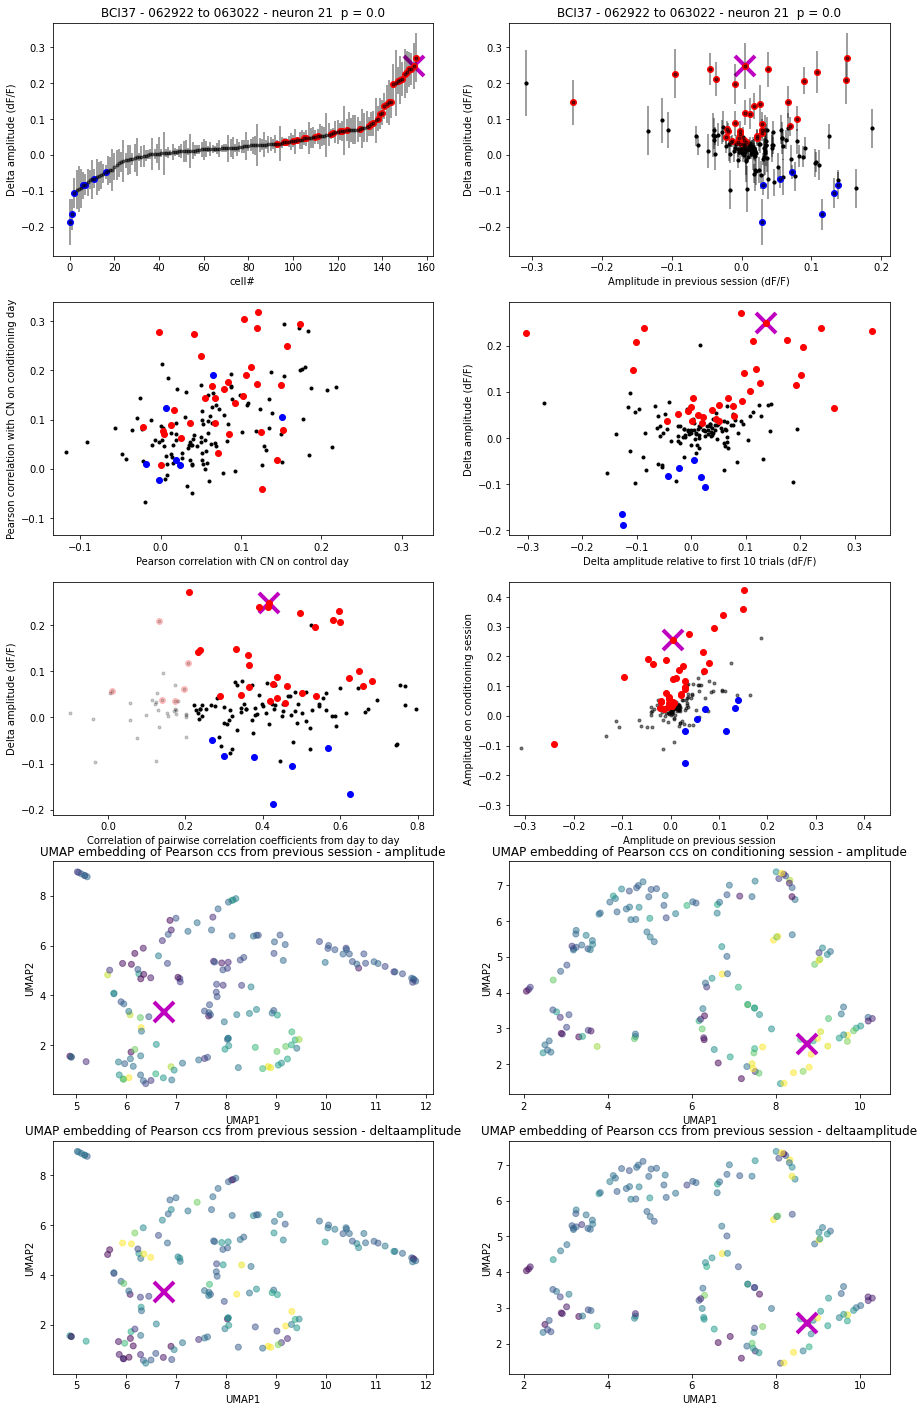

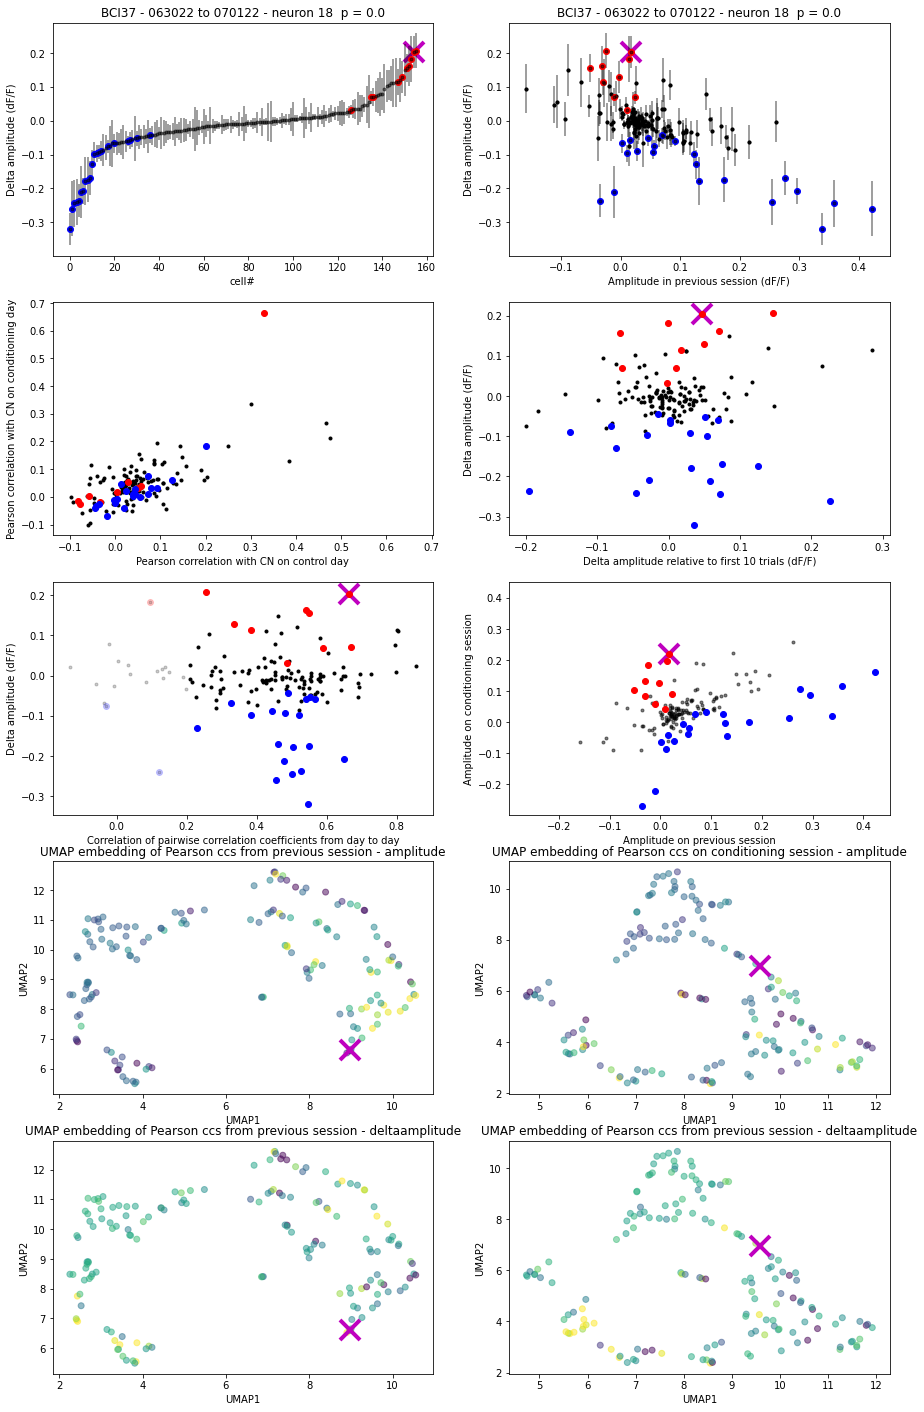

In [99]:
# bootstrapping of amplitudes 
#
import scipy
import umap
from sklearn.utils import resample
plot_amplitudes = True
multiple_correlations_per_pair = False
if multiple_correlations_per_pair:
    window_size_pearson = 1200
    pearson_corr_num = 100

max_p = .01#only for plotting significantly increasing cells
n_bootstrap = 1000
step_back = 40 #baseline before trial start (in frames)
step_forward = 100 #integration time after trial start (frames)
baseline_trial_num = 10
trace_time = np.arange(-step_back,step_forward)/20
# check if CNs are really increasing it's activity - who are the other cells that increase their activity
multi_session_dict['F_trialwise'] = [] #time x neuron x trial
multi_session_dict['F_rewardwise'] = [] #time x neuron x trial
multi_session_dict['amplitude'] = []
multi_session_dict['previous_amplitude'] = []
multi_session_dict['delta_amplitude'] = []
multi_session_dict['p_increase'] = []
multi_session_dict['p_decrease'] = []
multi_session_dict['baseline_amplitude'] = []
if 'pairwise_correlations_matrix' in multi_session_dict.keys():
    cc_already_done = True
else:
    cc_already_done = False
    multi_session_dict['pairwise_correlations_matrix'] = []
    if multiple_correlations_per_pair:
        multi_session_dict['pairwise_correlations_trace_matrix'] = []
    multi_session_dict['pairwise_correlations_matrix_p'] = []
    multi_session_dict['pearson_cc_with_cn'] = []
    multi_session_dict['pearson_cc_with_cn_yesterday'] = []
#cc_already_done = False
    
for session_i,session in enumerate(multi_session_dict['session']):
    print([multi_session_dict['mouse'][session_i],session])
    # trial_start_trace = np.zeros(multi_session_dict['F'][session_i].shape[1])
    # trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][session_i][:-1]])] = 1
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    F_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            multi_session_dict['reward_original'][session_i],
                                                                            max_frames=None,
                                                                            frames_after=5, 
                                                                            frames_before=5,
                                                                            include_next_trial=True)
    
    multi_session_dict['F_trialwise'].append(F_trialwise)
    multi_session_dict['F_rewardwise'].append(F_rewardwise)
    if not cc_already_done:
        pearson_correlation_matrix_all_cells = np.ones([multi_session_dict['F'][session_i].shape[0]]*2)*np.nan
        pearson_correlation_matrix_p_all_cells = np.ones([multi_session_dict['F'][session_i].shape[0]]*2)*np.nan
        pearson_correlation_matrix_population_all_cells = np.asarray(np.ones([multi_session_dict['F'][session_i].shape[0]]*2)*np.nan,dtype = object)
        frame_num = multi_session_dict['F'][session_i].shape[1]
        for neuron_id_to_compare in np.arange(multi_session_dict['F'][session_i].shape[0]):  #multi_session_dict['cn'][session_i]:
            for neuron_idx in np.arange(neuron_id_to_compare,multi_session_dict['F'][session_i].shape[0]):
                if neuron_idx == neuron_id_to_compare:#multi_session_dict['cn'][session_i]:
                    pearsons_R = np.nan
                    pearsons_p = np.nan
                    corr_list = []
                else:
                    pearsons_R, pearsons_p = scipy.stats.pearsonr(multi_session_dict['F'][session_i][neuron_idx,:],
                                                                   multi_session_dict['F'][session_i][neuron_id_to_compare,:])
                    if multiple_correlations_per_pair:
                        corr_list = []
                        window_center_list = []
                        window_step_pearson = int((frame_num-window_size_pearson)/pearson_corr_num)
                        for wstart in np.arange(0,frame_num-window_size_pearson,window_step_pearson):
                            wend = wstart + window_size_pearson
                            window_center_list.append(wstart+window_size_pearson/2)
                            pearsons_R, pearsons_p = scipy.stats.pearsonr(multi_session_dict['F'][session_i][neuron_idx,wstart:wend],  multi_session_dict['F'][session_i][neuron_id_to_compare,wstart:wend])
                            corr_list.append(pearsons_R)
                # if len(corr_list)>0:
                #     asdasd
                pearson_correlation_matrix_all_cells[neuron_id_to_compare,neuron_idx] = pearsons_R
                pearson_correlation_matrix_p_all_cells[neuron_id_to_compare,neuron_idx] = pearsons_p
                
                pearson_correlation_matrix_population_all_cells[neuron_id_to_compare,neuron_idx] = np.asarray(corr_list)
        #asdasd
        multi_session_dict['pairwise_correlations_matrix'].append(pearson_correlation_matrix_all_cells)
        if multiple_correlations_per_pair:
            multi_session_dict['pairwise_correlations_trace_matrix'].append(pearson_correlation_matrix_population_all_cells)
        multi_session_dict['pairwise_correlations_matrix_p'].append(pearson_correlation_matrix_p_all_cells)
    
    
    
    if session_i >0:
        if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i-1].shape[0]: #there is a previous session

            
            pearson_correlation_matrix_all_cells = multi_session_dict['pairwise_correlations_matrix'][session_i]
            pearson_correlation_matrix_all_cells_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]
            cn = multi_session_dict['cn'][session_i]
            pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
            multi_session_dict['pearson_cc_with_cn'].append(pearson_list)
            pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
            multi_session_dict['pearson_cc_with_cn_yesterday'].append(pearson_list_yesterday)
            
            now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
            prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
            real_deltas = np.nanmean(now_amplitudes,1)-np.nanmean(prev_amplitudes,1)
            cn = multi_session_dict['cn'][session_i]

            
            prev_mean_amplitude_bootstrap_list = []
            now_mean_amplitude_bootstrap_list = []

            for bootstrap_i in range(n_bootstrap):
                now_indices = resample(np.arange(now_amplitudes.shape[1]))
                now_mean_amplitude_bootstrap_list.append(np.mean(now_amplitudes[:,now_indices],1))
                prev_indices = resample(np.arange(prev_amplitudes.shape[1]))
                prev_mean_amplitude_bootstrap_list.append(np.mean(prev_amplitudes[:,prev_indices],1))
            now_mean_amplitude_bootstrap_list = np.asarray(now_mean_amplitude_bootstrap_list)
            prev_mean_amplitude_bootstrap_list = np.asarray(prev_mean_amplitude_bootstrap_list)
            delta_amplitudes_bootstrap = now_mean_amplitude_bootstrap_list-prev_mean_amplitude_bootstrap_list
            delta_sd = np.std(delta_amplitudes_bootstrap,0)


            cell_order = np.argsort(real_deltas)
            significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cell_order]<max_p
            significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)[cell_order]<max_p
            
            multi_session_dict['delta_amplitude'].append(real_deltas)
            multi_session_dict['p_increase'].append(1-np.nanmean(delta_amplitudes_bootstrap>0,0))
            multi_session_dict['p_decrease'].append(1-np.nanmean(delta_amplitudes_bootstrap<0,0))
            multi_session_dict['amplitude'].append(np.nanmean(now_amplitudes,1))
            multi_session_dict['previous_amplitude'].append(np.nanmean(prev_amplitudes,1))
            baseline_amplitudes = np.nanmean(now_amplitudes[:,:baseline_trial_num],1)
            multi_session_dict['baseline_amplitude'].append(baseline_amplitudes)
            if plot_amplitudes:
                fig = plt.figure(figsize = [15,30])
                ax = fig.add_subplot(6,2,1)

                ax.plot(np.argmax(cell_order==cn),real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.errorbar(np.arange(len(cell_order)),real_deltas[cell_order],yerr = delta_sd[cell_order],fmt='.',color = 'black',alpha = .5)
                ax.plot(np.arange(len(cell_order))[significantly_increasing_indices],real_deltas[cell_order][significantly_increasing_indices],'ro')
                ax.plot(np.arange(len(cell_order))[significantly_decreasing_indices],real_deltas[cell_order][significantly_decreasing_indices],'bo')
                ax.set_xlabel('cell#')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))
                significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)<max_p
                significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)<max_p
                #now_ampls = sklearn.utils.resample(now_amplitudes)

                ax = fig.add_subplot(6,2,2)
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(np.nanmean(prev_amplitudes,1),real_deltas,'.',color = 'black')
                ax.errorbar(np.nanmean(prev_amplitudes,1),real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_increasing_indices],real_deltas[significantly_increasing_indices],'ro')
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_decreasing_indices],real_deltas[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Amplitude in previous session (dF/F)')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))     
                ax = fig.add_subplot(6,2,4)
                today_deltas = np.nanmean(now_amplitudes,1)-baseline_amplitudes
                #ax.plot(today_deltas,real_deltas,'k.')
                
                ax.plot(today_deltas[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(today_deltas,real_deltas,'.',color = 'black')
                #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(today_deltas[significantly_increasing_indices],real_deltas[significantly_increasing_indices],'ro')
                ax.plot(today_deltas[significantly_decreasing_indices],real_deltas[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Delta amplitude relative to first {} trials (dF/F)'.format(baseline_trial_num))
                ax.set_ylabel('Delta amplitude (dF/F)')
                
                
                ax = fig.add_subplot(6,2,3)
                
                
                ax.plot(pearson_list_yesterday[cn],pearson_list[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(pearson_list_yesterday,pearson_list,'.',color = 'black')
                #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(pearson_list_yesterday[significantly_increasing_indices],pearson_list[significantly_increasing_indices],'ro')
                ax.plot(pearson_list_yesterday[significantly_decreasing_indices],pearson_list[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Pearson correlation with CN on control day')
                ax.set_ylabel('Pearson correlation with CN on conditioning day')
                limits = [ax.get_xlim(),ax.get_ylim()]
                limits = [np.min(limits),np.max(limits)]
                ax.set_xlim(limits)
                ax.set_ylim(limits)
                
                pearson_correlation_matrix_all_cells = multi_session_dict['pairwise_correlations_matrix'][session_i]
                pearson_correlation_matrix_all_cells_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]
                pearson_2_list = []
                pearson_2_p_list = []
                for cell_idx in np.arange(pearson_correlation_matrix_all_cells.shape[0]):
                    x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
                    y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
                    needed = (np.isnan(x)==False) & (np.isnan(y)==False)
                    pearsons_R, pearsons_p = scipy.stats.pearsonr(x[needed],y[needed])
                    pearson_2_list.append(pearsons_R)
                    pearson_2_p_list.append(pearsons_p)
                pearson_2_list = np.asarray(pearson_2_list)
                pearson_2_p_list = np.asarray(pearson_2_p_list)
                significant = pearson_2_p_list<.01
                insignificant = pearson_2_p_list>=.01
                ax = fig.add_subplot(6,2,5)
                ax.plot(pearson_2_list[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                
                ax.plot(pearson_2_list[insignificant],real_deltas[insignificant],'.',color = 'black',alpha = .2)
                ax.plot(pearson_2_list[significant],real_deltas[significant],'.',color = 'black',alpha = 1)
                #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(pearson_2_list[significantly_increasing_indices&insignificant],real_deltas[significantly_increasing_indices&insignificant],'ro',alpha = .2)
                ax.plot(pearson_2_list[significantly_decreasing_indices&insignificant],real_deltas[significantly_decreasing_indices&insignificant],'bo',alpha = .2)
                ax.plot(pearson_2_list[significantly_increasing_indices&significant],real_deltas[significantly_increasing_indices&significant],'ro',alpha = 1)
                ax.plot(pearson_2_list[significantly_decreasing_indices&significant],real_deltas[significantly_decreasing_indices&significant],'bo',alpha = 1)
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_xlabel('Correlation of pairwise correlation coefficients from day to day')
                
                
                ax = fig.add_subplot(6,2,6)
                
                ax.plot(np.nanmean(prev_amplitudes,1),np.nanmean(now_amplitudes,1),'k.',alpha= .5)#real_deltas,
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],np.nanmean(now_amplitudes,1)[cn],'mx',markersize = 20,markeredgewidth = 4)
                
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_increasing_indices],np.nanmean(now_amplitudes,1)[significantly_increasing_indices],'ro')
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_decreasing_indices],np.nanmean(now_amplitudes,1)[significantly_decreasing_indices],'bo')
                limits = np.concatenate([ax.get_xlim(),ax.get_ylim()])
                limits = [np.min(limits),np.max(limits)]
                ax.set_xlim(limits)
                ax.set_ylim(limits)
                ax.set_xlabel('Amplitude on previous session')
                ax.set_ylabel('Amplitude on conditioning session')
                
                amplitude_color_edges = np.percentile(np.concatenate([np.nanmean(now_amplitudes,1),np.nanmean(prev_amplitudes,1)]),[5,95])
                
                
                ax = fig.add_subplot(6,2,7)
                matrix_now = np.nanmean([pearson_correlation_matrix_all_cells_yesterday,pearson_correlation_matrix_all_cells_yesterday.T],0)
                matrix_now[np.isnan(matrix_now)] = 1
                reducer = umap.UMAP()

                #sil = []
                #kmax = 20
                reducer.n_neighbors=5
                reducer.min_dist = 0.05 
                umap_embedding = reducer.fit_transform(matrix_now)

                coordinates = umap_embedding

                # ax.plot(coordinates[:,0],coordinates[:,1],'k.',alpha = .5)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= np.nanmean(prev_amplitudes,1),
                           alpha = .5,
                           vmin = amplitude_color_edges[0],
                          vmax =  amplitude_color_edges[1])
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs from previous session - amplitude')
                
                ax = fig.add_subplot(6,2,9)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= real_deltas,
                           alpha = .5,
                           vmin = np.percentile(real_deltas,5),
                          vmax =  np.percentile(real_deltas,95))
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs from previous session - deltaamplitude')
                
                
                ax = fig.add_subplot(6,2,8)
                matrix_now = np.nanmean([pearson_correlation_matrix_all_cells,pearson_correlation_matrix_all_cells.T],0)
                matrix_now[np.isnan(matrix_now)] = 1
                reducer = umap.UMAP()

                #sil = []
                #kmax = 20
                reducer.n_neighbors=5
                reducer.min_dist = 0.05 
                umap_embedding = reducer.fit_transform(matrix_now)

                coordinates = umap_embedding

                # ax.plot(coordinates[:,0],coordinates[:,1],'k.',alpha = .5)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                #ax.scatter(coordinates[:,0],coordinates[:,1],c= np.nanmean(now_amplitudes,1),alpha = .5) #-np.nanmean(prev_amplitudes,1)
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= np.nanmean(now_amplitudes,1),
                           alpha = .5,
                           vmin = amplitude_color_edges[0],
                           vmax =  amplitude_color_edges[1])
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs on conditioning session - amplitude')
                
                ax = fig.add_subplot(6,2,10)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= real_deltas,
                           alpha = .5,
                           vmin = np.percentile(real_deltas,5),
                          vmax =  np.percentile(real_deltas,95))
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs from previous session - deltaamplitude')
                #asdasd
            continue
    multi_session_dict['delta_amplitude'].append([])
    multi_session_dict['p_increase'].append([])
    multi_session_dict['p_decrease'].append([])
    multi_session_dict['amplitude'].append([])
    multi_session_dict['previous_amplitude'].append([])
    multi_session_dict['pearson_cc_with_cn'].append([])
    multi_session_dict['pearson_cc_with_cn_yesterday'].append([])
    #asdsa
            
            

In [231]:
# get betas out of all increasing cells for each session to identify movements
import scipy
#stats_metadata_ALL = np.load('/home/jupyter/bucket/Data/Behavior_videos/Fitted_metadata/incrasing_cells_mat_lasso.npy',allow_pickle = True).tolist()
# project movements onto weights and see if it changes from session to session
#stats_metadata_ALL = np.load('/home/jupyter/bucket/Data/Behavior_videos/Fitted_metadata/non_changing_cells_mat_ridge.npy',allow_pickle = True).tolist()
#stats_metadata_ALL = np.load('/home/jupyter/bucket/Data/Behavior_videos/Fitted_metadata/increasing_cells_mat_ridge.npy',allow_pickle = True).tolist()
#stats_metadata_ALL = np.load('/home/jupyter/bucket/Data/Behavior_videos/Fitted_metadata/decreasing_cells_mat_ridge.npy',allow_pickle = True).tolist()
#stats_metadata_ALL = np.load('/home/jupyter/bucket/Data/Behavior_videos/Fitted_metadata/CNs_mat_ridge.npy',allow_pickle = True).tolist()
# stats_metadata_ALL = np.load('/home/jupyter/bucket/Data/Behavior_videos/Fitted_metadata/CNs_mat_ridge_optimized_for_pearsons.npy',allow_pickle = True).tolist()
# stats_metadata_ALL = np.load('/home/jupyter/bucket/Data/Behavior_videos/Fitted_metadata/increasing_cells_mat_ridge_optimized_for_pearsons.npy',allow_pickle = True).tolist()
#stats_metadata_ALL = np.load('/home/jupyter/bucket/Data/Behavior_videos/Fitted_metadata/decreasing_cells_mat_ridge_deconvolved.npy',allow_pickle = True).tolist()
stats_metadata_ALL = np.load('/home/jupyter/bucket/Data/Behavior_videos/Fitted_metadata/CNs_on_previous_day_mat_ridge.npy',allow_pickle = True).tolist()

subtract_baseline = True
baseline_frame_num = 3
max_p_val = .01#np.max([0.1,np.sort(beta_pvals)[3]])
# get data
mean_fit_session_fit_list = []
mean_test_session_fit_list = []
mean_fit_session_dff_list = []
mean_test_session_dff_list = []
indices_to_use = np.where((np.asarray(stats_metadata_ALL['r2_test_p'])<.05) & (np.asarray(stats_metadata_ALL['r2_test_median'])>0))[0]
#indices_to_use = np.where((np.asarray(stats_metadata_ALL['pearsons_test_p'])<.05) & (np.asarray(stats_metadata_ALL['pearsons_test_r_median'])>0))[0]
# indices_to_use = np.where(np.asarray(stats_metadata_ALL['r2_test_p'])<.01)[0]
# indices_to_use = np.where((np.asarray(stats_metadata_ALL['r2_test_p'])<.01) & (np.asarray(stats_metadata_ALL['r2_test_median'])>.1) & (np.asarray(stats_metadata_ALL['r2_test_session_median'])>.1))[0]
#indices_to_use = [60]
#indices_to_use = np.arange(len(np.asarray(stats_metadata_ALL['pearsons_test_p'])))

beta_test_sessions = []
beta_lists = []
neuron_idx_lists = []
neuron_idx_list_now = []
beta_list_now = []
corr_coef_list = []
corr_coef_list_previous_session = []
cc_now_list = []
cc_now_list_previous_session = []


significant_beta_values = []
mean_movement_fit = []
mean_movement_test = []

test_session_now = stats_metadata_ALL['mat_idx_test'][indices_to_use[0]]
for idx_to_use in indices_to_use:#:#=  np.argsort(stats_metadata_ALL['r2_test_median'])[::-1][1]
   # print(idx_to_use)
    
    fit_session = stats_metadata_ALL['mat_idx_train'][idx_to_use]
    fit_session_name = stats_metadata_ALL['train_sessions'][idx_to_use]
    test_session = stats_metadata_ALL['mat_idx_test'][idx_to_use]
    test_session_name = stats_metadata_ALL['session'][idx_to_use]
    stats_dict = stats_metadata_ALL['stat_dict'][idx_to_use]
    cn = stats_metadata_ALL['neuron_index'][idx_to_use] 
    cn_real = multi_session_dict['cn'][test_session]
    DLC_aligned_fit_session = multi_session_dict['DLC_aligned'][fit_session].copy()
    F_fit_session = multi_session_dict['F'][fit_session]
    DLC_aligned_test_session = multi_session_dict['DLC_aligned'][test_session].copy()
    F_test_session = multi_session_dict['F'][test_session].copy()

    
    trial_end_frames_fit_session = np.asarray(multi_session_dict['trial_end_frames'][fit_session])
    trial_start_frames_fit_session_ = np.concatenate([[0],trial_end_frames_fit_session[:-1]])
    trial_start_frames_fit_session = np.zeros(multi_session_dict['F'][fit_session].shape[1])
    trial_start_frames_fit_session[trial_start_frames_fit_session_] = 1
    
    trial_end_frames_test_session = np.asarray(multi_session_dict['trial_end_frames'][test_session])
    trial_start_frames_test_session_ = np.concatenate([[0],trial_end_frames_test_session[:-1]])
    trial_start_frames_test_session = np.zeros(multi_session_dict['F'][test_session].shape[1])
    trial_start_frames_test_session[trial_start_frames_test_session_] = 1
    
    
    
    
    for k in DLC_aligned_fit_session.keys():
        if 'mean' in k:# subtract mean from the raw position from day to day
            DLC_aligned_fit_session[k] = DLC_aligned_fit_session[k] - np.nanmean(DLC_aligned_fit_session[k])
            DLC_aligned_test_session[k] = DLC_aligned_test_session[k] - np.nanmean(DLC_aligned_test_session[k])


    DLC_aligned_all = pd.concat([DLC_aligned_fit_session, DLC_aligned_test_session], ignore_index=True)

    for k in DLC_aligned_all.keys(): # remove eye and likelihood
        if 'likelihood'in k or 'eye' in k[0].lower() or 'pole' in k[0].lower():
            DLC_aligned_all.pop(k)
            DLC_aligned_fit_session.pop(k)
            DLC_aligned_test_session.pop(k)
    for k in DLC_aligned_all.keys(): # remove lickport
        if 'lickport' in k[0].lower() or 'pole' in k[0].lower():# or 'mean' in k:# or 'NoseTip' in k: #remove mean as well
            DLC_aligned_all.pop(k)
            DLC_aligned_fit_session.pop(k)
            DLC_aligned_test_session.pop(k)

    for k in DLC_aligned_all.keys(): # normalize movement data (two sessions together)
        DLC_aligned_fit_session[k] = (DLC_aligned_fit_session[k] - DLC_aligned_all[k].mean())/DLC_aligned_all[k].std()
        DLC_aligned_test_session[k] = (DLC_aligned_test_session[k] - DLC_aligned_all[k].mean())/DLC_aligned_all[k].std()
        DLC_aligned_all[k] = (DLC_aligned_all[k] - DLC_aligned_all[k].mean())/DLC_aligned_all[k].std()

    # get betas

    beta_pvals = np.nanmin(1-np.asarray([np.nanmean(np.asarray(stats_dict['betas'])<0,0),np.nanmean(np.asarray(stats_dict['betas'])>0,0)]),0)
    
    
    median_betas = np.zeros(len(stats_dict['betas'][0]))
    for part_idx in np.argsort(beta_pvals):#[1:]:
        if beta_pvals[part_idx]>max_p_val:
            break
        median_betas[part_idx] = np.nanmean(np.asarray(stats_dict['betas'])[:,part_idx])
    if np.max(median_betas) == 0:
        continue # no betas..
    
    if test_session != test_session_now:
        beta_test_sessions.append(test_session_now)
        beta_lists.append(beta_list_now)
        test_session_now = test_session
        beta_list_now = []
        
        neuron_idx_lists.append(neuron_idx_list_now)
        neuron_idx_list_now = []
        
        
        
        
        corr_coef_list.append(cc_now_list)
        cc_now_list = []
        corr_coef_list_previous_session.append(cc_now_list_previous_session)
        cc_now_list_previous_session = []
        
        
        
        
    beta_list_now.append(median_betas)
    neuron_idx_list_now.append(cn)
    dff1 = multi_session_dict['F'][test_session][cn,:]
    dff2 = multi_session_dict['F'][test_session][cn_real,:]
    window_size =2000
    window_step = 200
    corr_list = []        
    for wstart in np.arange(0,len(dff1)-window_size+window_step,window_step):
        wend = wstart + window_size
        pearsons_R, pearsons_p = scipy.stats.pearsonr(dff1[wstart:wend], dff2[wstart:wend])
        corr_list.append(pearsons_R)
    #pearsons_R_now, pearsons_p = scipy.stats.pearsonr(multi_session_dict['F'][test_session][cn,:],multi_session_dict['F'][test_session][cn_real,:])
    cc_now_list.append(corr_list)


    dff1 = multi_session_dict['F'][fit_session][cn,:]
    dff2 = multi_session_dict['F'][fit_session][cn_real,:]
    corr_list = []        
    for wstart in np.arange(0,len(dff1)-window_size+window_step,window_step):
        wend = wstart + window_size
        pearsons_R, pearsons_p = scipy.stats.pearsonr(dff1[wstart:wend], dff2[wstart:wend])
        corr_list.append(pearsons_R)
    #pearsons_R_now, pearsons_p = scipy.stats.pearsonr(multi_session_dict['F'][test_session][cn,:],multi_session_dict['F'][test_session][cn_real,:])
    cc_now_list_previous_session.append(corr_list)
        
    
    #project    
    X = DLC_aligned_fit_session
    Y = F_fit_session[cn,:]
    Y_fitted = (median_betas@X.T)
    X_test = DLC_aligned_test_session
    Y_test = F_test_session[cn,:]
    Y_test_fitted = (median_betas@X_test.T)

    #plot

    start_frame = 0
    step_back = 0
    step_forward = 100
    time_trace = np.arange(-step_back,step_forward,1)/20
    trial_start_trace = np.zeros(DLC_aligned_fit_session.shape[0])
    trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][fit_session][:-1]])] = 1
    fit_session_F = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_fit_session,
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back)
    fit_session_F = fit_session_F[:,cn,:]
    fit_session_F_fitted = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(np.asarray([Y_fitted]*2), 
                                                                                    trial_start_trace,
                                                                                    max_frames=None,
                                                                                    frames_after=step_forward, 
                                                                                    frames_before=step_back)

    fit_session_F_fitted = fit_session_F_fitted[:,0,:]

    trial_start_trace = np.zeros(DLC_aligned_test_session.shape[0])
    trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][test_session][:-1]])] = 1
    test_session_F = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_test_session,
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back)
    test_session_F = test_session_F[:,cn,:]
    test_session_F_fitted = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(np.asarray([Y_test_fitted]*2), 
                                                                                    trial_start_trace,
                                                                                    max_frames=None,
                                                                                    frames_after=step_forward, 
                                                                                    frames_before=step_back)
    
    
    test_session_F_fitted = test_session_F_fitted[:,0,:]
    
    mean_fit_session_fit = np.nanmean(fit_session_F_fitted,1)
    mean_test_session_fit = np.nanmean(test_session_F_fitted,1)
    mean_fit_session_dff = np.nanmean(fit_session_F,1)
    mean_test_session_dff = np.nanmean(test_session_F,1)
    if subtract_baseline:
        mean_fit_session_fit -= np.nanmean(mean_fit_session_fit[:baseline_frame_num]) 
        mean_test_session_fit -= np.nanmean(mean_test_session_fit[:baseline_frame_num]) 
        mean_fit_session_dff -= np.nanmean(mean_fit_session_dff[:baseline_frame_num]) 
        mean_test_session_dff -= np.nanmean(mean_test_session_dff[:baseline_frame_num]) 
    
    mean_fit_session_fit_list.append(mean_fit_session_fit)
    mean_test_session_fit_list.append(mean_test_session_fit)

    mean_fit_session_dff_list.append(mean_fit_session_dff)
    mean_test_session_dff_list.append(mean_test_session_dff)
    
    
    for part_i_now,beta_now in enumerate(median_betas):
        part_name = list(DLC_aligned_fit_session.keys())[part_i_now]
        if np.abs(beta_now)==0:# or 'diff' in part_name:
            continue
        #beta_now = beta_now/np.nanmax(np.abs(median_betas))
        part_name = list(DLC_aligned_fit_session.keys())[part_i_now]
        dlc_trace_fit = DLC_aligned_fit_session[part_name].values 
        dlc_trace_test = DLC_aligned_test_session[part_name].values 
        
        
        dlc_trace_trial_locked_fit = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(np.asarray([dlc_trace_fit,dlc_trace_fit]), 
                                                                                            trial_start_frames_fit_session,
                                                                                            max_frames=None,
                                                                                            frames_after=100, 
                                                                                            frames_before=0,
                                                                                            include_next_trial = False)
        dlc_trace_trial_locked_fit = dlc_trace_trial_locked_fit[:,0,:].squeeze().T
        dlc_trace_trial_locked_test = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(np.asarray([dlc_trace_test,dlc_trace_test]), 
                                                                                            trial_start_frames_test_session,
                                                                                            max_frames=None,
                                                                                            frames_after=100, 
                                                                                            frames_before=0,
                                                                                            include_next_trial = False)
        dlc_trace_trial_locked_test = dlc_trace_trial_locked_test[:,0,:].squeeze().T
        
        if subtract_baseline:
            dlc_trace_trial_locked_test_mean = np.nanmean(dlc_trace_trial_locked_test - np.nanmean(dlc_trace_trial_locked_test[:,:baseline_frame_num],1)[:,np.newaxis])
            dlc_trace_trial_locked_fit_mean = np.nanmean(dlc_trace_trial_locked_fit - np.nanmean(dlc_trace_trial_locked_fit[:,:baseline_frame_num],1)[:,np.newaxis])
        else:
            dlc_trace_trial_locked_test_mean = np.nanmean(dlc_trace_trial_locked_test)
            dlc_trace_trial_locked_fit_mean = np.nanmean(dlc_trace_trial_locked_fit)
        
        # dlc_trace_trial_locked_fit_mean = np.nanmean(dlc_trace_trial_locked_fit,0)
        # dlc_trace_trial_locked_test_mean = np.nanmean(dlc_trace_trial_locked_test,0)
        # dlc_trace_trial_locked_fit_mean -= dlc_trace_trial_locked_fit_mean[0]
        # dlc_trace_trial_locked_test_mean -= dlc_trace_trial_locked_test_mean[0]
        
#        asdsa
        significant_beta_values.append(beta_now)
        mean_movement_fit.append(np.nanmean(dlc_trace_trial_locked_fit_mean))
        mean_movement_test.append(np.nanmean(dlc_trace_trial_locked_test_mean))


# fig = plt.figure(figsize = [20,20])
# ax_fit_session = fig.add_subplot(3,2,1)
# ax_fit_session.plot(time_trace,np.nanmean(fit_session_F,1),'g-',label = 'mean neuron {} dF/F on {}'.format(cn, fit_session_name))
# ax_fit_session.plot(time_trace,np.nanmean(fit_session_F_fitted,1),'k-',label = 'best fit movement projections')
# ax_fit_session.legend()
# ax_fit_session.set_xlabel('Time from trial start (s)')
# ax_fit_session.set_ylabel('dF/F')
# ax_test_session = fig.add_subplot(3,2,2,sharey  = ax_fit_session)
# ax_test_session.plot(time_trace,np.nanmean(test_session_F,1),'g-',label = 'mean neuron {} dF/F on {}'.format(cn, test_session_name))
# ax_test_session.plot(time_trace,np.nanmean(test_session_F_fitted,1),'k-',label ='best fit movement projections')
# ax_test_session.legend()
# ax_test_session.set_xlabel('Time from trial start (s)')
# ax_test_session.set_ylabel('dF/F')


# ax_fit_session = fig.add_subplot(3,2,3)
# ax_fit_session.imshow(fit_session_F.T,aspect = 'auto')
# ax_fit_session.axes.get_xaxis().set_visible(False)
# ax_fit_session.set_ylabel('Trial#')
# ax_fit_session.set_title('neuron {} on {}'.format(cn, fit_session_name))
# ax_test_session = fig.add_subplot(3,2,4)
# ax_test_session.imshow(test_session_F.T,aspect = 'auto')
# ax_test_session.axes.get_xaxis().set_visible(False)
# ax_test_session.set_title('neuron {} on {}'.format(cn, test_session_name))
# ax_test_session.set_ylabel('Trial#')
# ax_fit_session = fig.add_subplot(3,2,5)
# ax_fit_session.imshow(fit_session_F_fitted.T,aspect = 'auto')
# ax_fit_session.axes.get_xaxis().set_visible(False)
# ax_fit_session.set_ylabel('Trial#')
# ax_fit_session.set_title('projection on {}'.format(fit_session_name))
# ax_test_session = fig.add_subplot(3,2,6)
# ax_test_session.imshow(test_session_F_fitted.T,aspect = 'auto')
# ax_test_session.axes.get_xaxis().set_visible(False)
# ax_test_session.set_ylabel('Trial#')
# ax_test_session.set_title('projection on {}'.format(test_session_name))

In [ ]:
np.nanmedian

In [232]:
import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

Text(0, 0.5, 'change in mean movement amplitude')

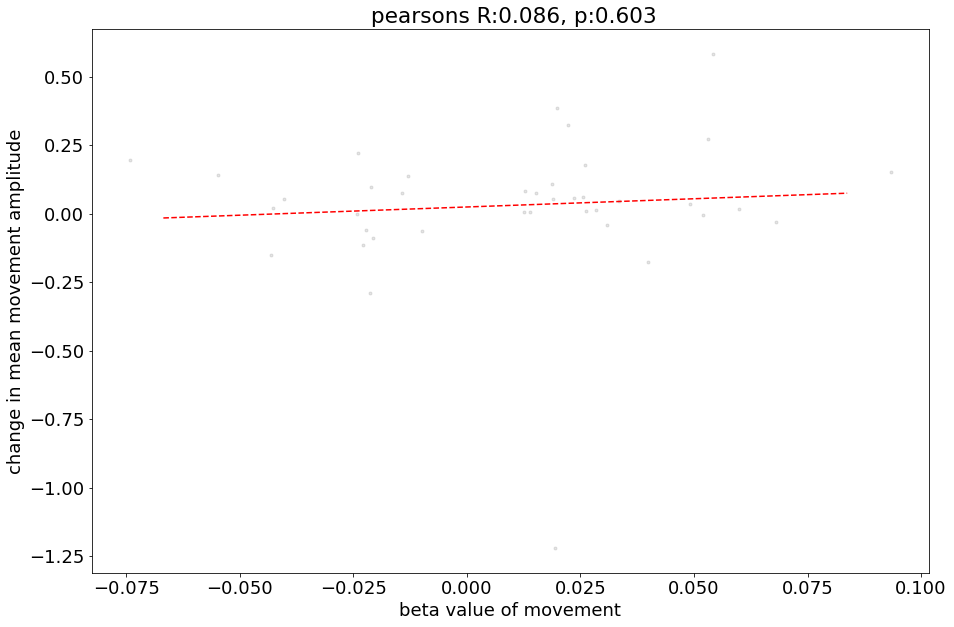

In [233]:
pearsons_R, pearsons_p = scipy.stats.pearsonr(significant_beta_values,np.asarray(mean_movement_test)-np.asarray(mean_movement_fit))
p = np.polyfit(significant_beta_values,np.asarray(mean_movement_test)-np.asarray(mean_movement_fit),1)
fig = plt.figure(figsize = [15,10])
ax1 = fig.add_subplot(1,1,1)
ax1.plot(significant_beta_values,np.asarray(mean_movement_test)-np.asarray(mean_movement_fit),'k.',alpha = .1 )
xvals = np.percentile(significant_beta_values,[1,99])
ax1.plot(xvals,np.polyval(p,xvals),'r--')
ax1.set_title(' pearsons R:{}, p:{}'.format(np.round(pearsons_R,3),np.round(pearsons_p,3)))
ax1.set_xlabel('beta value of movement')
ax1.set_ylabel('change in mean movement amplitude')

Text(0, 0.5, 'predicted dF/F')

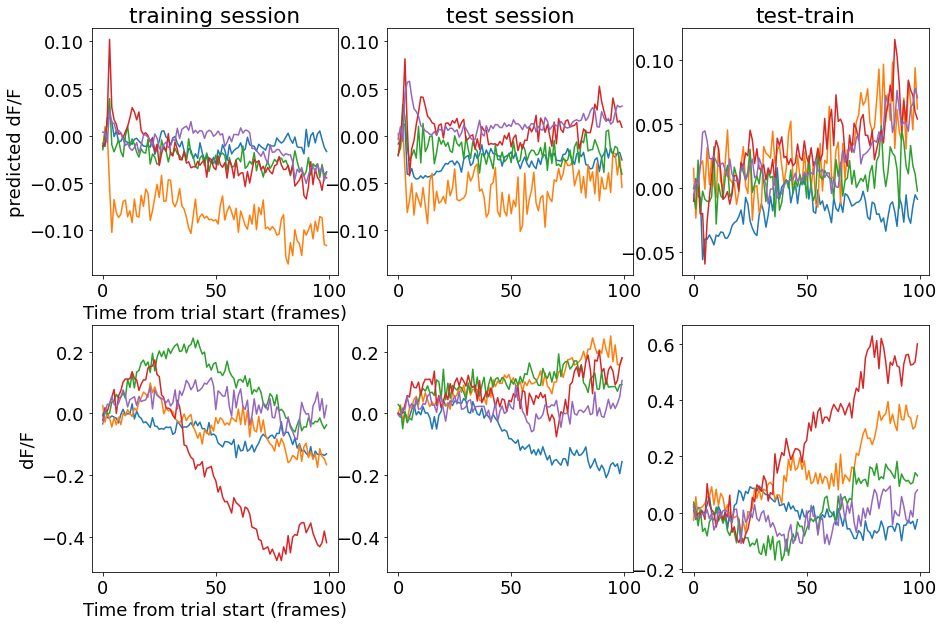

In [234]:
# look at fits

fig = plt.figure(figsize = [15,10])
ax_prev_session = fig.add_subplot(2,3,4)
ax_prev_session.set_ylabel('dF/F')
ax_prev_session.set_xlabel('Time from trial start (frames)')
ax_prev_session.plot(np.asarray(mean_fit_session_dff_list).T)
ax_current_session = fig.add_subplot(2,3,5,sharey = ax_prev_session)
ax_current_session.plot(np.asarray(mean_test_session_dff_list).T)
ax_diff = fig.add_subplot(2,3,6)
ax_diff.plot(np.asarray(mean_test_session_dff_list).T-np.asarray(mean_fit_session_dff_list).T)


ax_prev_session = fig.add_subplot(2,3,1)
ax_prev_session.plot(np.asarray(mean_fit_session_fit_list).T)
ax_current_session = fig.add_subplot(2,3,2,sharey = ax_prev_session)
ax_current_session.plot(np.asarray(mean_test_session_fit_list).T)
ax_diff = fig.add_subplot(2,3,3)
ax_diff.plot(np.asarray(mean_test_session_fit_list).T-np.asarray(mean_fit_session_fit_list).T)

ax_prev_session.set_title('training session')
ax_current_session.set_title('test session')
ax_diff.set_title('test-train')
ax_prev_session.set_xlabel('Time from trial start (frames)')
ax_prev_session.set_ylabel('predicted dF/F')


4
(25646, 108)


/tmp/ipykernel_32214/1374773839.py:172: RuntimeWarning: Mean of empty slice
  ax.imshow(np.nanmean(dff_trialwise,1).squeeze().T,aspect = 'auto',interpolation = 'none')


3
(27896, 108)
1
(19573, 108)
6
(25513, 108)


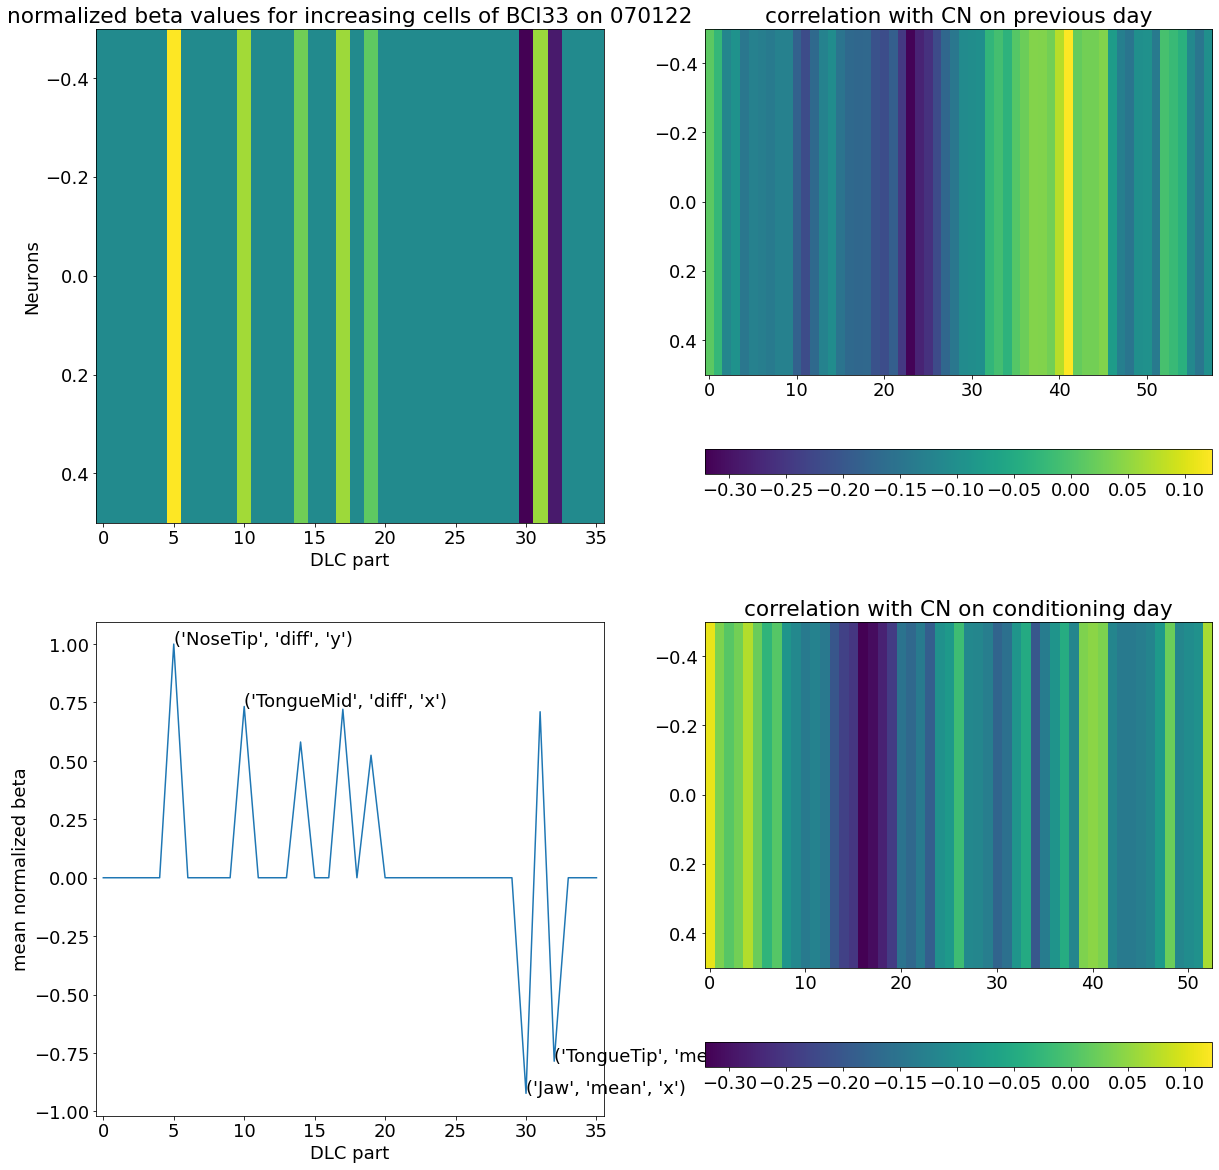

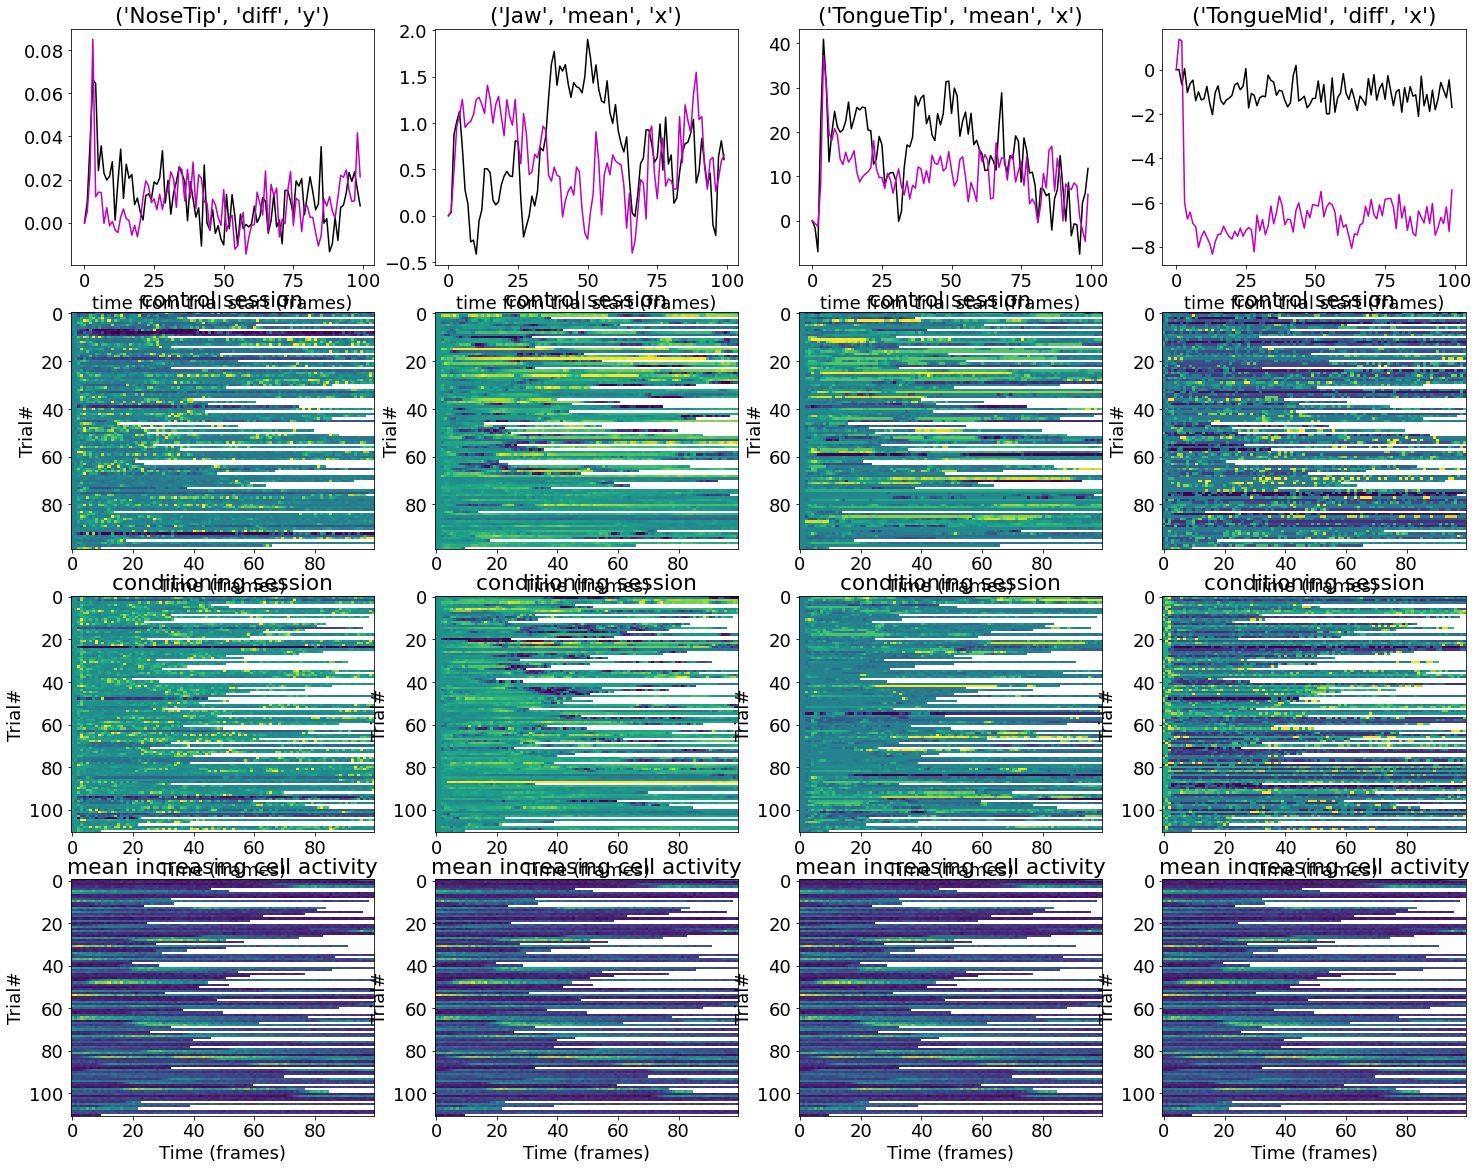

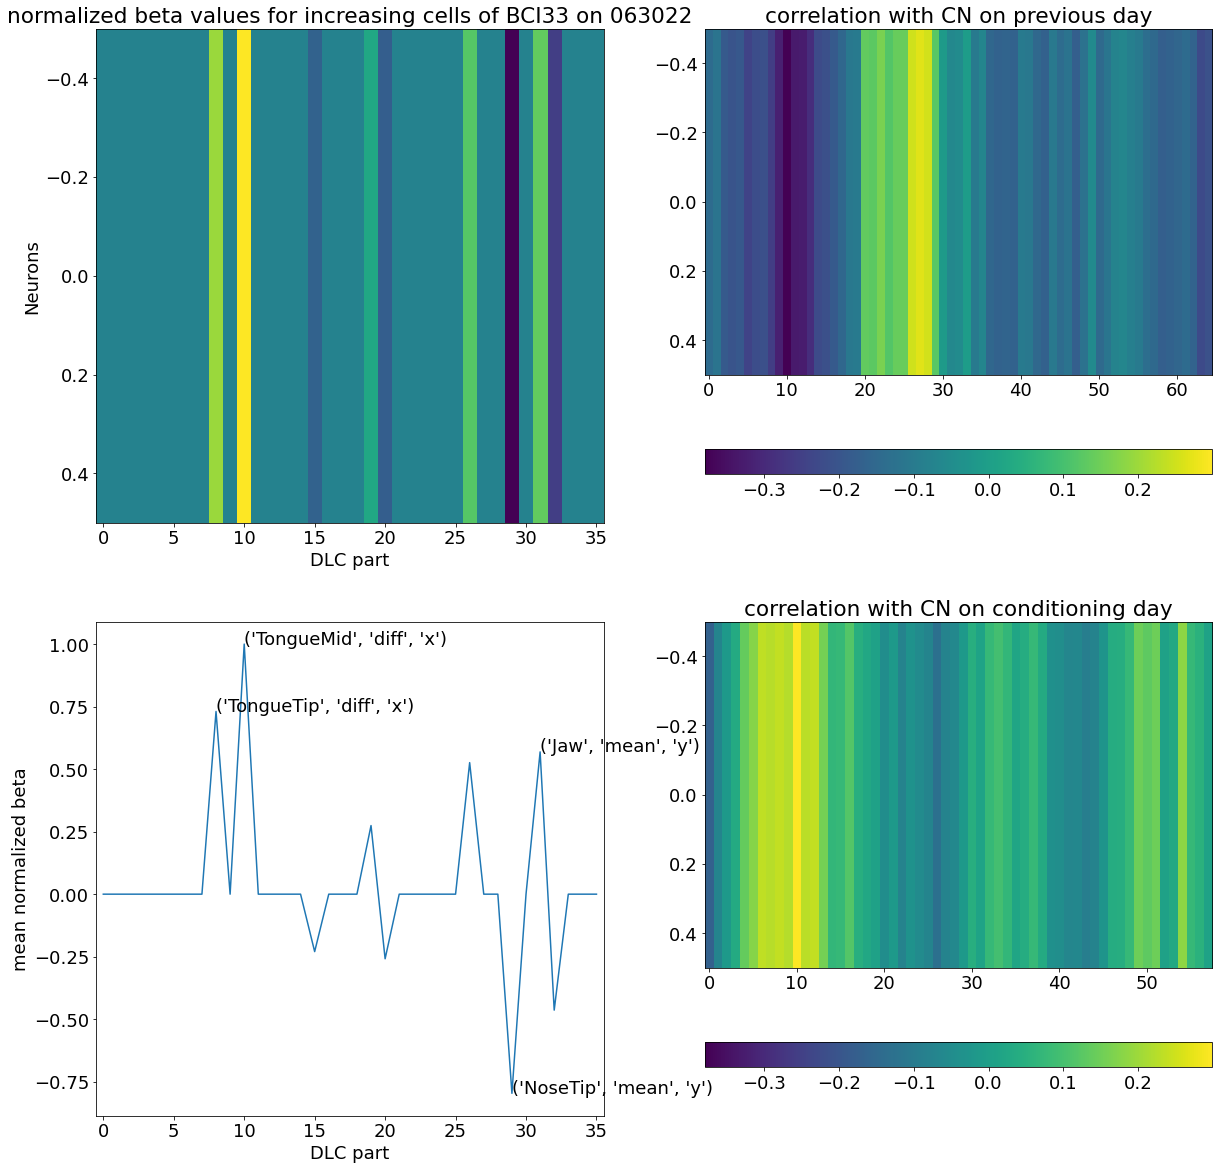

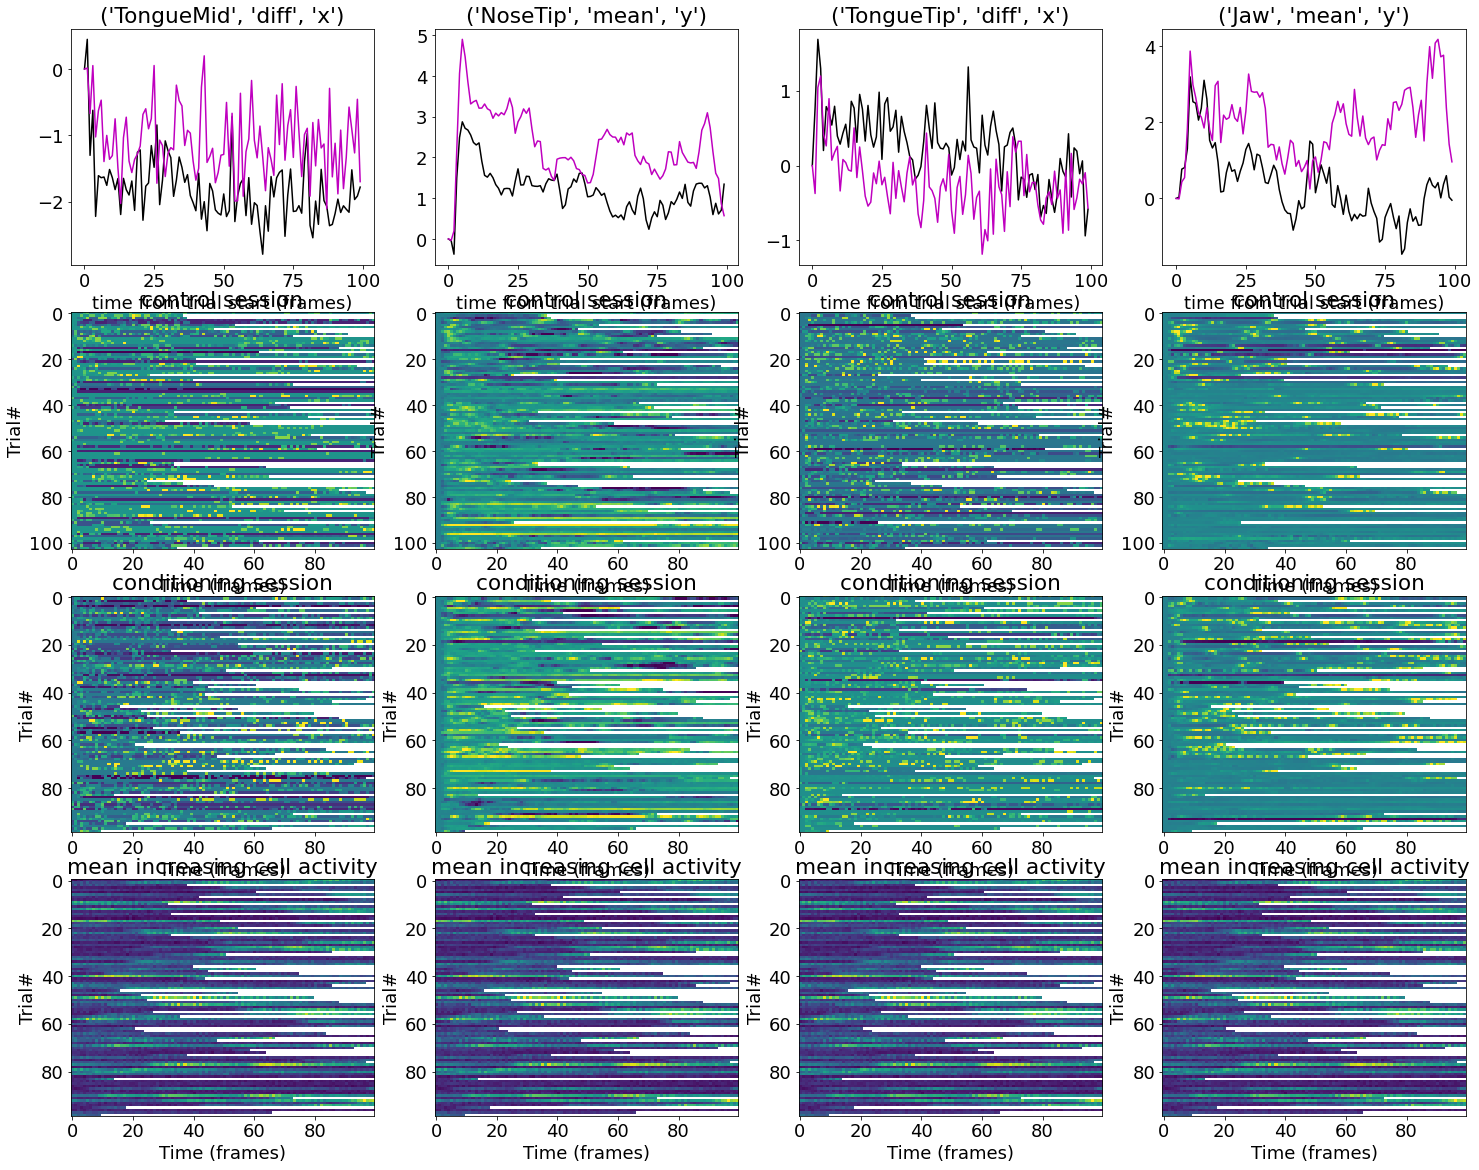

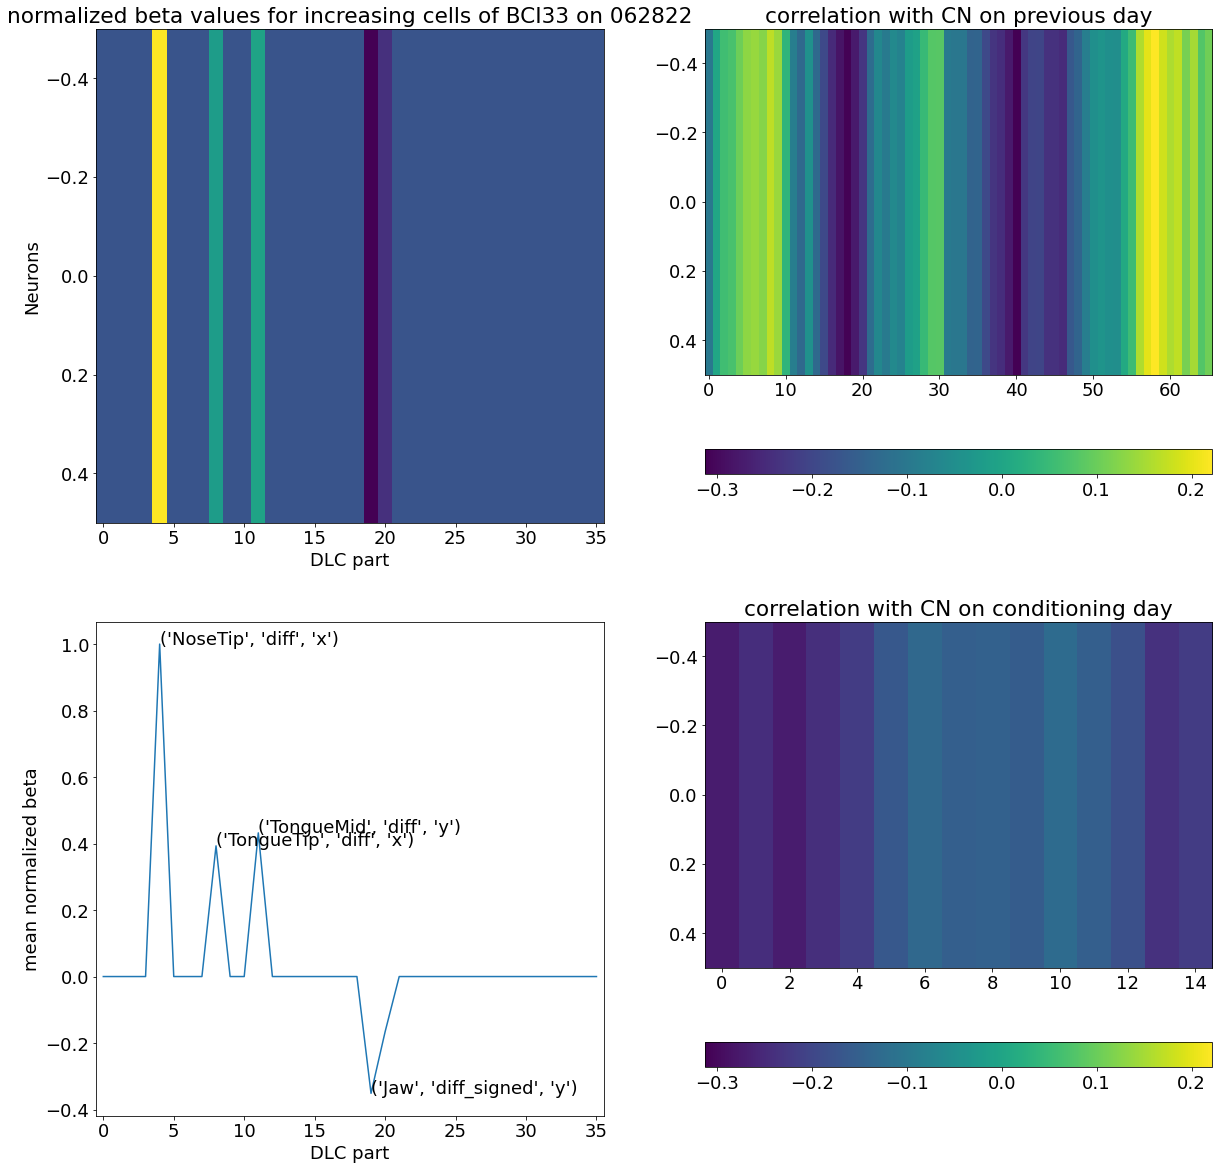

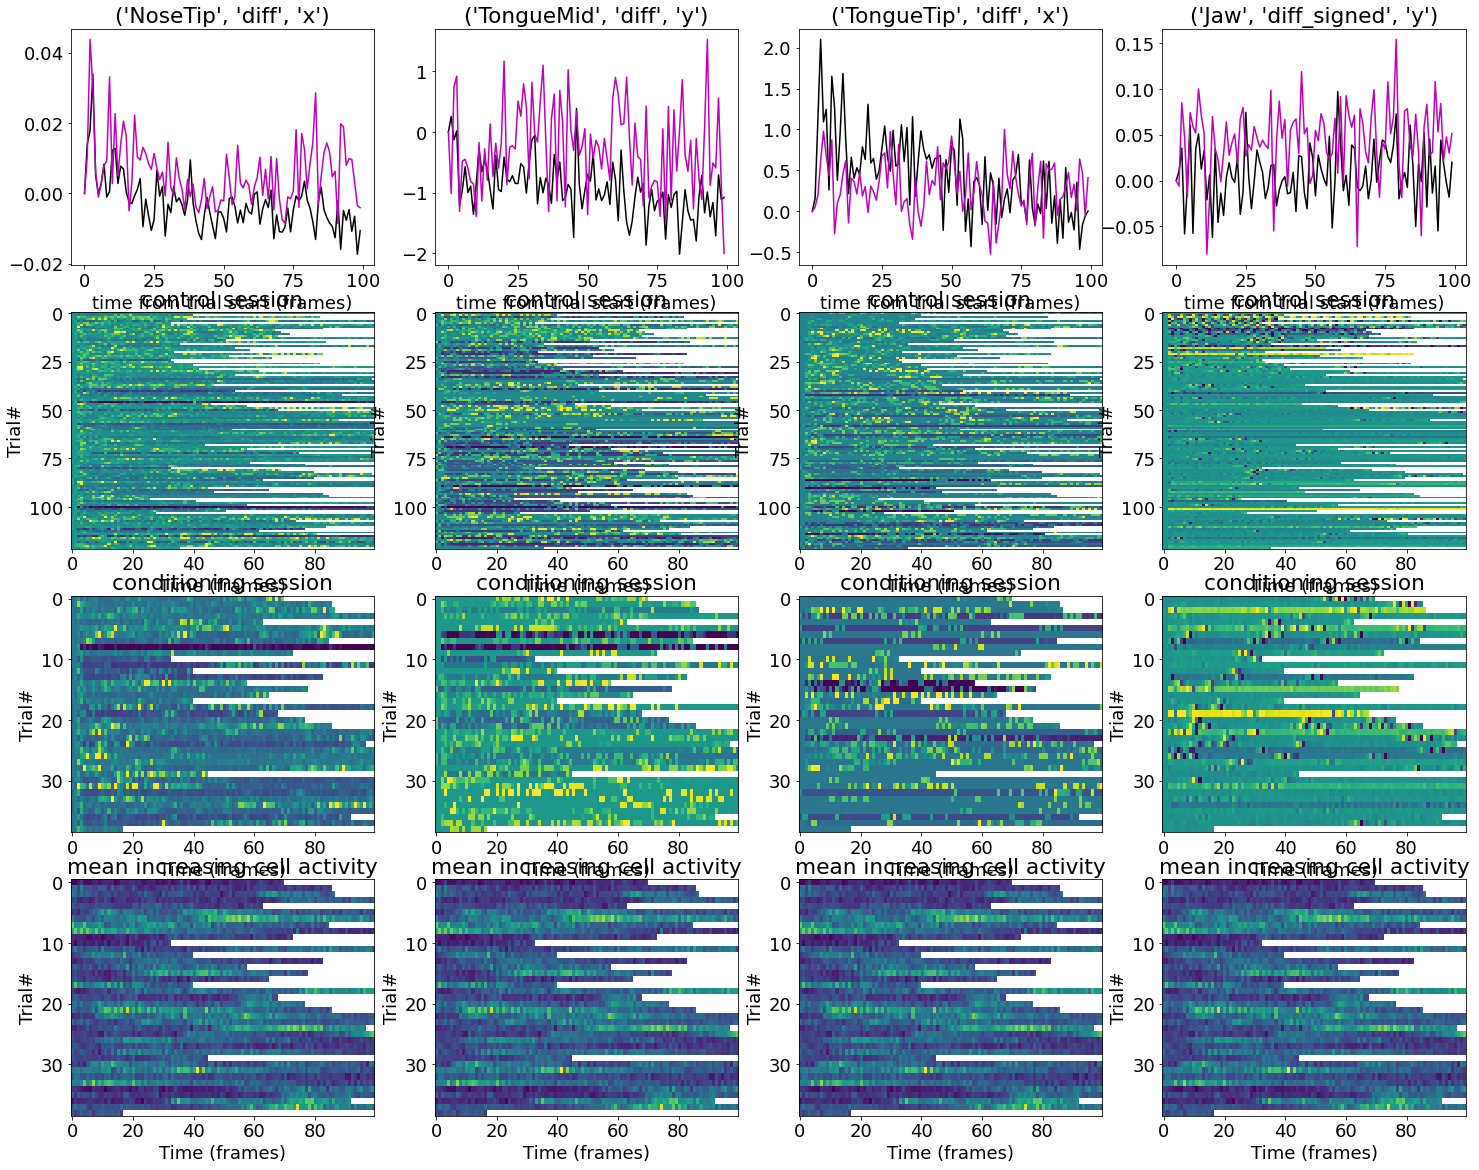

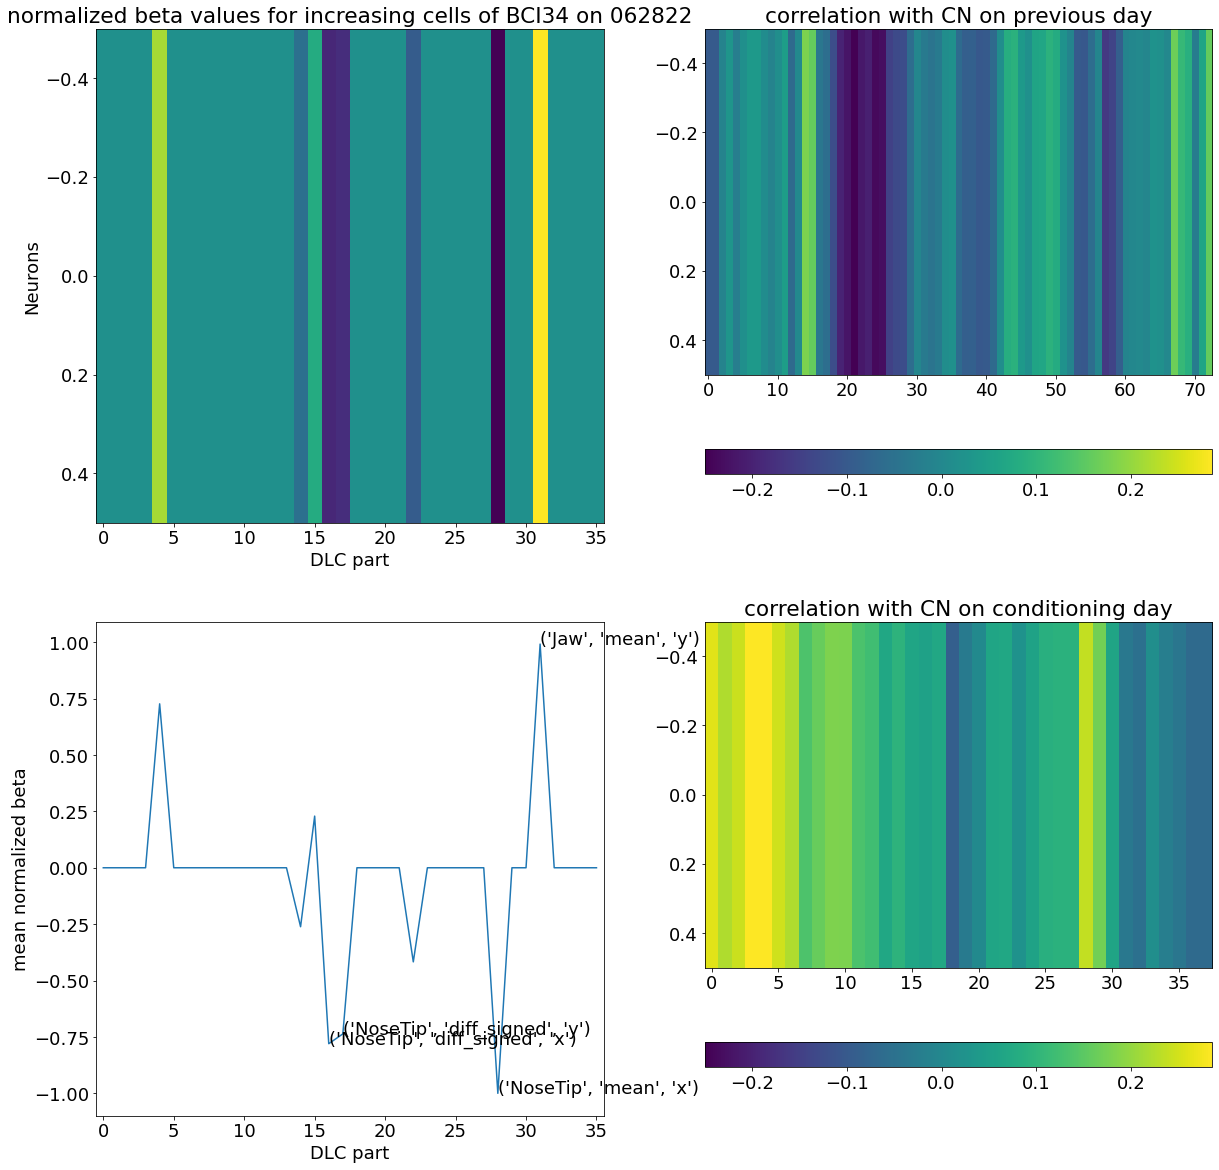

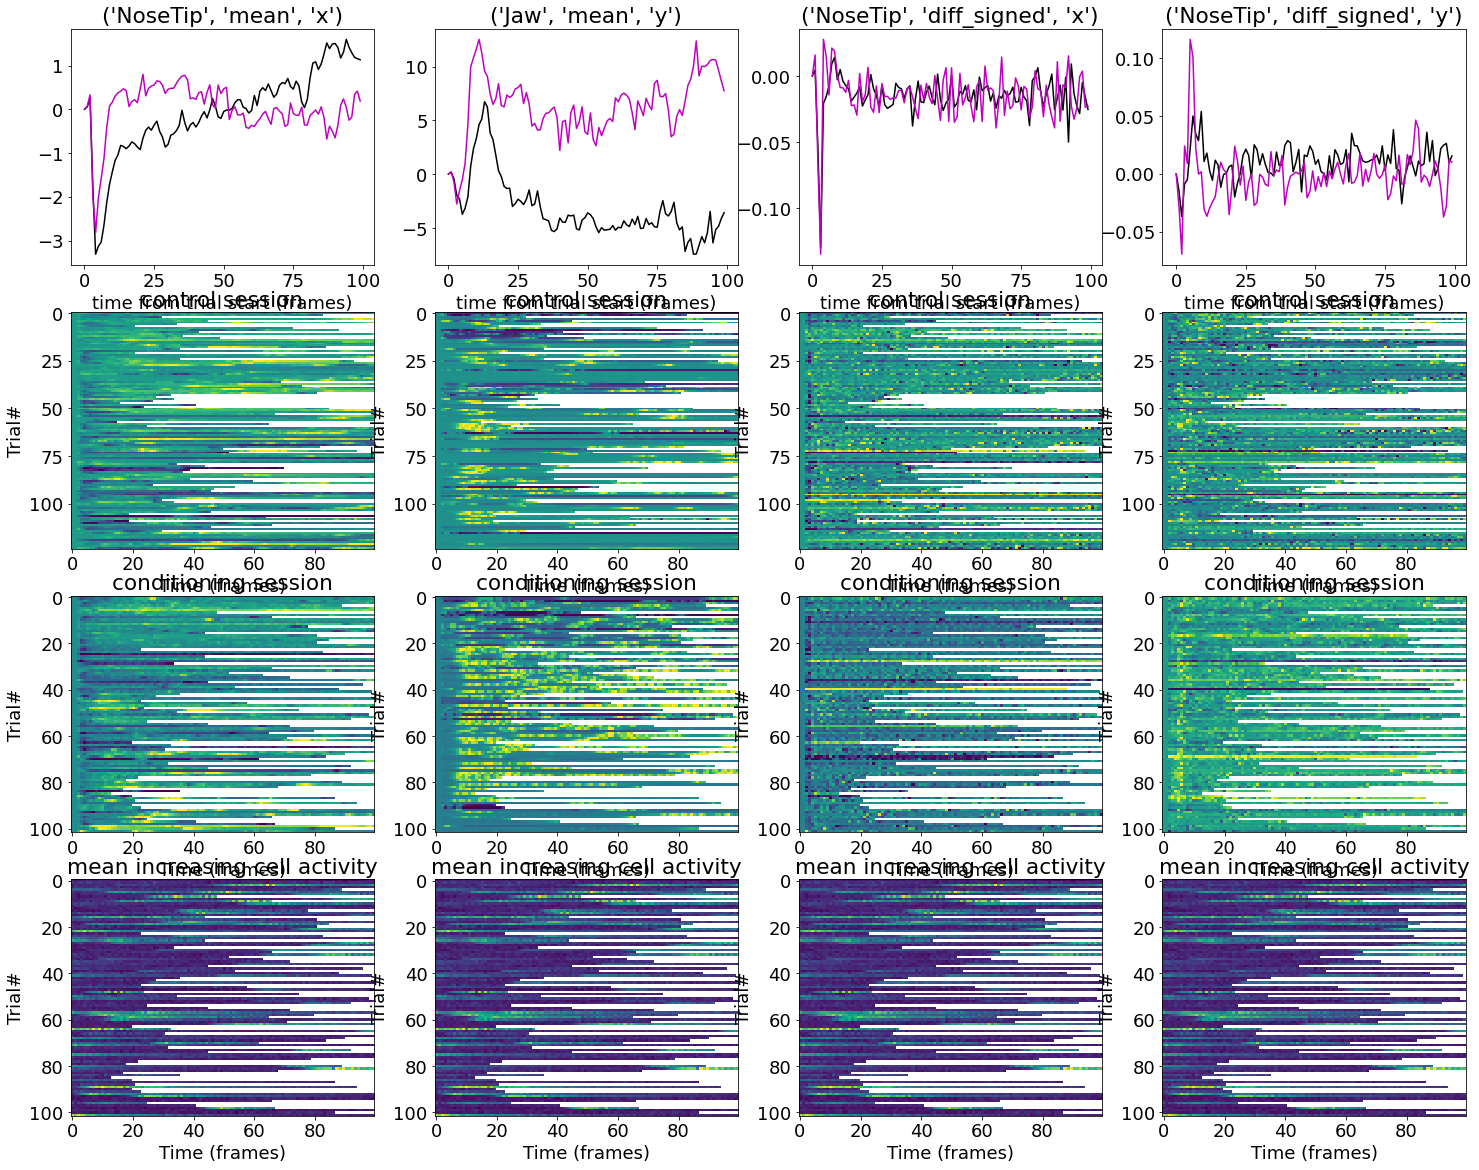

In [235]:
#create DLC stuff here and show how movements changed




for beta_list,session_i,corrcoefs,corrcoefs_previous_session,neuron_indices in zip(beta_lists,beta_test_sessions,corr_coef_list,corr_coef_list_previous_session,neuron_idx_lists):
    print(session_i)
    if len(beta_list)==0:
        continue
    #asdsad
    normalized_betas = np.asarray(beta_list)/np.max(np.abs(np.asarray(beta_list)),1)[:,np.newaxis]
    fig = plt.figure(figsize = [20,20])
    ax = fig.add_subplot(2,2,1)
    ax.imshow(normalized_betas,aspect = 'auto',interpolation = 'none')
    ax.set_xlabel('DLC part')
    ax.set_ylabel('Neurons')
    ax.set_title('normalized beta values for increasing cells of {} on {}'.format(multi_session_dict['mouse'][session_i],multi_session_dict['session'][session_i]))
    ax_mean = fig.add_subplot(2,2,3,sharex = ax)
    ax_mean.plot(np.nanmean(normalized_betas,0))
    ax_mean.set_xlabel('DLC part')
    ax_mean.set_ylabel('mean normalized beta')
    ax_ccs = fig.add_subplot(2,2,4)
    corr_matrix = np.asarray(corrcoefs)
    im = ax_ccs.imshow(corr_matrix,aspect = 'auto',interpolation='none')
    fig.colorbar(im, ax=ax_ccs,location = 'bottom')
    ax_ccs.set_title('correlation with CN on conditioning day')
    
    ax_ccs_prev = fig.add_subplot(2,2,2)
    corr_matrix = np.asarray(corrcoefs_previous_session)
    im_prev = ax_ccs_prev.imshow(corr_matrix,aspect = 'auto',interpolation='none')
    fig.colorbar(im_prev, ax=ax_ccs_prev,location = 'bottom')
    ax_ccs_prev.set_title('correlation with CN on previous day')
    
    im.set_clim([np.min([im_prev.get_clim()[0],im.get_clim()[0]]),np.max([im_prev.get_clim()[1],im.get_clim()[1]])])
    im_prev.set_clim([np.min([im_prev.get_clim()[0],im.get_clim()[0]]),np.max([im_prev.get_clim()[1],im.get_clim()[1]])])
    
    
    
    
    
    test_session = session_i
    fit_session = session_i - 1
    dff_session  = multi_session_dict['F'][test_session]
    

    trial_end_frames_fit_session = np.asarray(multi_session_dict['trial_end_frames'][fit_session])
    trial_start_frames_fit_session_ = np.concatenate([[0],trial_end_frames_fit_session[:-1]])
    trial_start_frames_fit_session = np.zeros(multi_session_dict['F'][fit_session].shape[1])
    trial_start_frames_fit_session[trial_start_frames_fit_session_] = 1
    
    trial_end_frames_test_session = np.asarray(multi_session_dict['trial_end_frames'][test_session])
    trial_start_frames_test_session_ = np.concatenate([[0],trial_end_frames_test_session[:-1]])
    trial_start_frames_test_session = np.zeros(multi_session_dict['F'][test_session].shape[1])
    trial_start_frames_test_session[trial_start_frames_test_session_] = 1
    
    
    
    dff_increasing = dff_session[np.asarray(neuron_indices),:]
    
    dff_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(dff_increasing, 
                                                                            trial_start_frames_test_session,
                                                                            max_frames=None,
                                                                            frames_after=100, 
                                                                            frames_before=0,
                                                                            include_next_trial = False)
    
    DLC_aligned_fit_session = multi_session_dict['DLC_aligned'][fit_session].copy()
    DLC_aligned_test_session = multi_session_dict['DLC_aligned'][test_session].copy()

    for k in DLC_aligned_fit_session.keys():
        if 'mean' in k:# subtract mean from the raw position from day to day
            DLC_aligned_fit_session[k] = DLC_aligned_fit_session[k] - np.nanmean(DLC_aligned_fit_session[k])
            DLC_aligned_test_session[k] = DLC_aligned_test_session[k] - np.nanmean(DLC_aligned_test_session[k])


    DLC_aligned_all = pd.concat([DLC_aligned_fit_session, DLC_aligned_test_session], ignore_index=True)
    print(DLC_aligned_all.shape)



    for k in DLC_aligned_all.keys(): # remove eye and likelihood
        if 'likelihood'in k or 'eye' in k[0].lower() or 'pole' in k[0].lower():
            DLC_aligned_all.pop(k)
            DLC_aligned_fit_session.pop(k)
            DLC_aligned_test_session.pop(k)
    for k in DLC_aligned_all.keys(): # remove lickport
        if 'lickport' in k[0].lower() or 'pole' in k[0].lower():# or 'mean' in k:# or 'NoseTip' in k: #remove mean as well
            DLC_aligned_all.pop(k)
            DLC_aligned_fit_session.pop(k)
            DLC_aligned_test_session.pop(k)

    # for k in DLC_aligned_all.keys(): # normalize movement data (two sessions together)
    #     DLC_aligned_fit_session[k] = (DLC_aligned_fit_session[k] - DLC_aligned_all[k].mean())/DLC_aligned_all[k].std()
    #     DLC_aligned_test_session[k] = (DLC_aligned_test_session[k] - DLC_aligned_all[k].mean())/DLC_aligned_all[k].std()
    #     DLC_aligned_all[k] = (DLC_aligned_all[k] - DLC_aligned_all[k].mean())/DLC_aligned_all[k].std()
    
    
    fig = plt.figure(figsize = [25,20])
    dlc_part_order = np.argsort(np.abs(np.nanmean(normalized_betas,0)))[::-1]
    for i,part_i_now in enumerate(dlc_part_order[:4]):
        part_name = list(DLC_aligned_fit_session.keys())[part_i_now]
        ax_mean.text(part_i_now,np.nanmean(normalized_betas,0)[part_i_now],part_name)
        dlc_trace_fit = DLC_aligned_fit_session[part_name].values 
        dlc_trace_test = DLC_aligned_test_session[part_name].values 
        
        
        dlc_trace_trial_locked_fit = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(np.asarray([dlc_trace_fit,dlc_trace_fit]), 
                                                                                            trial_start_frames_fit_session,
                                                                                            max_frames=None,
                                                                                            frames_after=100, 
                                                                                            frames_before=0,
                                                                                            include_next_trial = False)
        dlc_trace_trial_locked_fit = dlc_trace_trial_locked_fit[:,0,:].squeeze().T
        
        
        
        dlc_trace_trial_locked_test = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(np.asarray([dlc_trace_test,dlc_trace_test]), 
                                                                                            trial_start_frames_test_session,
                                                                                            max_frames=None,
                                                                                            frames_after=100, 
                                                                                            frames_before=0,
                                                                                            include_next_trial = False)
        dlc_trace_trial_locked_test = dlc_trace_trial_locked_test[:,0,:].squeeze().T
        
        
        dlc_trace_trial_locked_fit_mean = np.nanmean(dlc_trace_trial_locked_fit,0)
        dlc_trace_trial_locked_test_mean = np.nanmean(dlc_trace_trial_locked_test,0)
        dlc_trace_trial_locked_fit_mean -= dlc_trace_trial_locked_fit_mean[0]
        dlc_trace_trial_locked_test_mean -= dlc_trace_trial_locked_test_mean[0]
        
        
        
        dlc_trace_trial_locked_fit -= np.nanmean(dlc_trace_trial_locked_fit[:,0:2],1)[:,np.newaxis]
        dlc_trace_trial_locked_fit_flat = dlc_trace_trial_locked_fit.flatten()
        dlc_trace_trial_locked_fit_flat = dlc_trace_trial_locked_fit_flat[np.isnan(dlc_trace_trial_locked_fit_flat)==False]
        ax= fig.add_subplot(4,4,4+(i+1))
        im = ax.imshow(dlc_trace_trial_locked_fit,aspect = 'auto',interpolation = 'none')
        im.set_clim(np.percentile(dlc_trace_trial_locked_fit_flat,[1,99]))
        
        ax.set_title('control session')
        ax.set_xlabel('Time (frames)')
        ax.set_ylabel('Trial#')
        
        dlc_trace_trial_locked_test -= np.nanmean(dlc_trace_trial_locked_test[:,0:2],1)[:,np.newaxis]
        dlc_trace_trial_locked_test_flat = dlc_trace_trial_locked_test.flatten()
        dlc_trace_trial_locked_test_flat = dlc_trace_trial_locked_test_flat[np.isnan(dlc_trace_trial_locked_test_flat)==False]
        ax= fig.add_subplot(4,4,8+(i+1))
        im = ax.imshow(dlc_trace_trial_locked_test,aspect = 'auto',interpolation = 'none')
        im.set_clim(np.percentile(dlc_trace_trial_locked_test_flat,[1,99]))
        
        ax.set_title('conditioning session')
        ax.set_xlabel('Time (frames)')
        ax.set_ylabel('Trial#')
        
        ax= fig.add_subplot(4,4,(i+1))
#         ax.imshow(np.concatenate([dlc_trace_trial_locked_fit,dlc_trace_trial_locked_test],0),aspect = 'auto',interpolation = 'none')
#         ax.hlines(dlc_trace_trial_locked_fit.shape[0],ax.get_xlim()[0],ax.get_xlim()[1],color = 'red',linewidth = 4)
        
        
        
        #ax.plot(np.concatenate([dlc_trace_fit,dlc_trace_test]))
        #ax.vlines(len(dlc_trace_fit),ax.get_ylim()[0],ax.get_ylim()[1],color = 'red')
        
        
    
        ax.plot(dlc_trace_trial_locked_fit_mean,'k-')
        ax.plot(dlc_trace_trial_locked_test_mean,'m-')
        
        ax.set_xlabel('time from trial start (frames)')
        ax.set_title(part_name)
        ax= fig.add_subplot(4,4,(i+1)+12)
        ax.imshow(np.nanmean(dff_trialwise,1).squeeze().T,aspect = 'auto',interpolation = 'none')
        ax.set_title('mean increasing cell activity')
        ax.set_xlabel('Time (frames)')
        ax.set_ylabel('Trial#')
    #asdas